In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')

# Making results folder -- change to what this should actually be 
path = '/Volumes/drive/AVP-BDD/'
os.chdir(path)


[fetch_surf_fsaverage] Dataset found in /Users/gilliangrennan/nilearn_data/fsaverage


In [3]:
layout = bids.BIDSLayout('/Volumes/drive/AVP-BDD/derivatives', validate=False,
                  config=['bids','derivatives'])
print(layout)
subjects = layout.get_subjects()

def load_bids_events(layout,onsets, subject, task, run):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = 1
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files[run])
    n_tr = func_file.shape[-1]
    onsets=onsets[run]
    #onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events')[run].path, sep='\t') -- line to use if events changes by 
    
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [1,4,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as "onsets_actua
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans


def create_low_events_file(file_path):
    data = pd.read_csv(file_path)  # Adjust delimiter if necessary

    # Define category mapping
    condition_mapping = {
        "Condition 1": "low-high", "Condition 2": "high-high", "Condition 3": "low-low", "Condition 4": "high-low"
    }

    data["Condition"] = data["Condition"].map(condition_mapping)

    # Extract unique blocks
    block_summary = data.groupby("Block").agg({
        "Stimulus Onset (s)": "first",
        "Stimulus Offset (s)": "last",
        "Condition": "first"
    }).reset_index()

    # Rename columns for clarity
    block_summary.rename(columns={
        "Stimulus Onset (s)": "onset",
        "Stimulus Offset (s)": "block_end",
        "Condition": "trial_type"
    }, inplace=True)
    
    block_summary["duration"] = block_summary["block_end"]-block_summary["onset"]
    block_summary["onset"] = np.round(block_summary["onset"])
    block_summary["duration"] = np.round(block_summary["duration"])

    # Save the processed data
    output_path = "/Volumes/drive/AVP-BDD/derivatives/events.csv"
    block_summary.to_csv(output_path, index=False)
    return block_summary



BIDS Layout: ...umes/drive/AVP-BDD/derivatives | Subjects: 59 | Sessions: 59 | Runs: 177


##### old (ignore)

In [ ]:

onsets = []
sub = '105' 
runs = ['1','2','3']
for run in runs:
    file_path = f"/Volumes/drive/AVP-BDD/derivatives/sub-{sub}/ses-01/func/Subject_{sub}_Run_1_RT.csv"
    onsets_temp = create_low_events_file(file_path)
    onsets.append(onsets_temp)

onsets

In [317]:
sub = sub
task = 'SFlow'

fmri_imgs = layout.get(subject=sub,
              datatype='func', task=task,
              desc='preproc',
              space='MNI152NLin2009cAsym',
              extension='nii.gz',
              return_type='file')
hrf_model = "spm" #canonical hrf 
high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

confound_files = layout.get(subject=sub,
                  datatype='func', task=task,
                  desc='confounds',
                  extension="tsv",
                  return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
  #32 confound_vars -- REMOVING GLOBAL SIGNAL 
confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                      'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                        'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                        'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                        'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                        'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                        'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                        'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                      ]

final_confounds = confound_vars

design_matrices = []
for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
    run = idx
    events,tr,n_scans = load_bids_events(layout,onsets, sub, task, run)
# Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    confound_file = confound_files[run]
    confound_df = pd.read_csv(confound_file, delimiter='\t')
    confound_df = confound_df[final_confounds]
    confound_df.fillna(0, inplace=True)
# Build design matrix with the previously defined parameters
    design_matrix = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        drift_model="polynomial",
        drift_order=3,
        add_regs=confound_df,
        add_reg_names=confound_vars,
        high_pass=high_pass,
    )
    design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
    if idx == 0:
        design_matrix['intercept1'] = 1 
        design_matrix['intercept2'] = 0
        design_matrix['intercept3'] = 0
    elif idx == 1:
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 1 
        design_matrix['intercept3'] = 0
    else: 
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 0 
        design_matrix['intercept3'] = 1
# put the design matrices in a list
    design_matrices.append(design_matrix)


contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = {
column: contrast_matrix[i]
for i, column in enumerate(design_matrix.columns)
}

contrasts = {
"all": (basic_contrasts["low-low"] + basic_contrasts["low-high"] + basic_contrasts["high-low"] + basic_contrasts["high-high"]),          
}
fmri_glm = FirstLevelModel()
fmri_glm = fmri_glm.fit(fmri_imgs, design_matrices=design_matrices)

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_86695/1952182048.py:4: UserWarning: One contrast given, assuming it for all 3 runs
  z_map = fmri_glm.compute_contrast(contrasts['all'], output_type="z_score")
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/plotting/find_cuts.py:66: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/reporting/get_clusters_table.py:302: UserWarning: The given float value must not exceed 0.0. But, you have given threshold=5.118127927025583.
  stat_img = threshold_img(


\begin{tabular}{lllllll}
\toprule
 & Cluster ID & X & Y & Z & Peak Stat & Cluster Size (mm3) \\
\midrule
\bottomrule
\end{tabular}



/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_86695/1952182048.py:22: UserWarning: Attention: No clusters with stat higher than 5.118127927025583
  table = get_clusters_table(clean_map, threshold, 10)


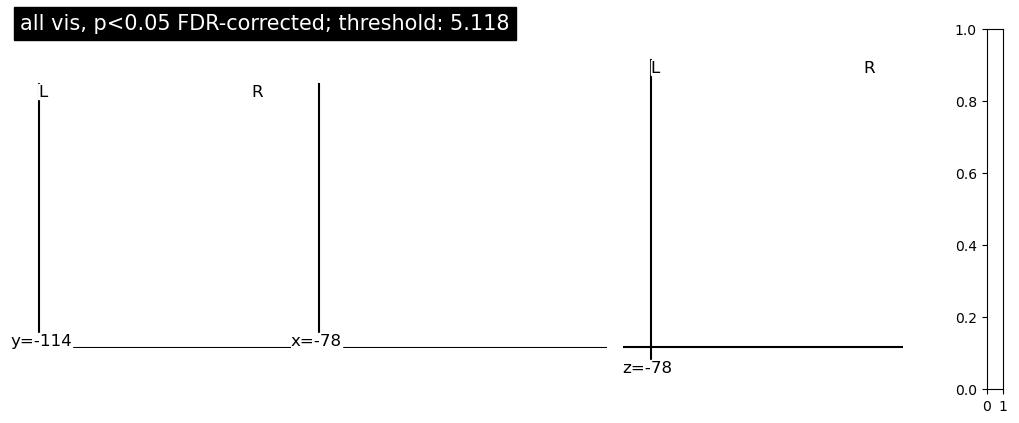

In [318]:
from nilearn.glm import threshold_stats_img
from nibabel import Nifti1Image

z_map = fmri_glm.compute_contrast(contrasts['all'], output_type="z_score")

clean_map, threshold = threshold_stats_img(z_map, alpha=0.05,height_control='fdr',cluster_threshold=30, two_sided=False)
plot_stat_map(clean_map,
    threshold=threshold,
    title=(f"all vis, p<0.05 FDR-corrected; threshold: {threshold:.3f}"),
    figure=plt.figure(figsize=(10, 4))
    )

#binarize mask 
data = clean_map.get_fdata()
binarized_data = (data > 0).astype(bool)
vis_mask = Nifti1Image(binarized_data, z_map.affine, header=z_map.header)
vis_mask.shape

# cluster summary table 

from nilearn.reporting import get_clusters_table
table = get_clusters_table(clean_map, threshold, 10)
print(table.to_latex())



/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/plotting/find_cuts.py:66: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


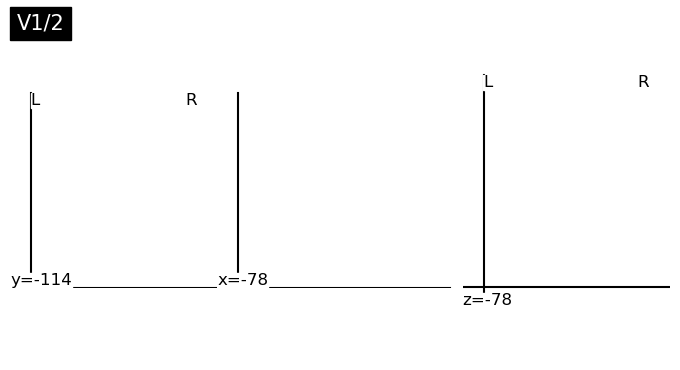

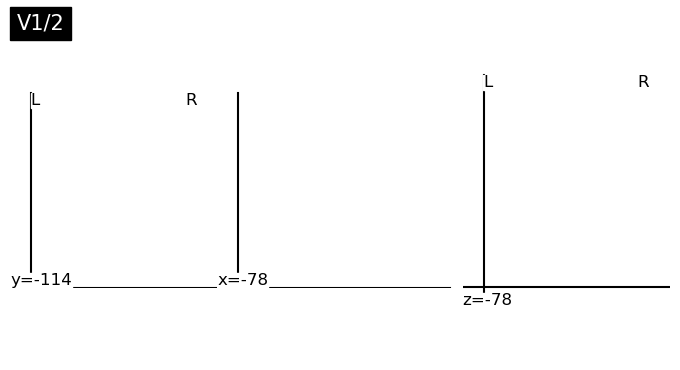

In [319]:
from nilearn.plotting import plot_roi, show
plot_roi(vis_mask,
    title='V1/2',
)

#adding dilation: 

from scipy.ndimage import binary_dilation
data = binary_dilation(binarized_data)
vis_mask_dil = Nifti1Image(data, z_map.affine, header=z_map.header)
plot_roi(vis_mask_dil,
    title='V1/2',
)


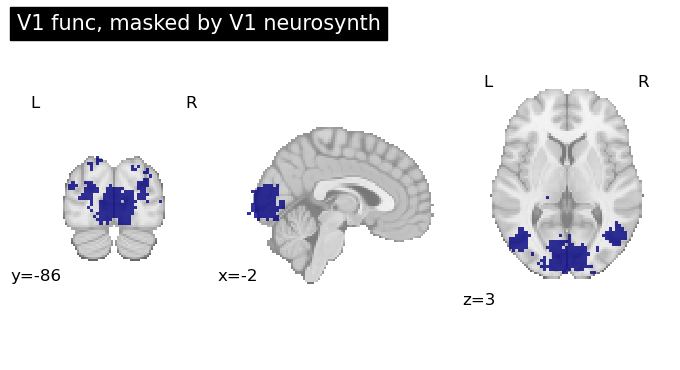

In [331]:
#Also masking w neurosynth v1? 
from nilearn.image import new_img_like
from nilearn.image import resample_to_img 

#import DMN Neurosynth mask:
v1_raw = load_img('/Volumes/Seagate Desktop Drive/AVP-BDD/v1.nii.gz')
v1 = resample_to_img(source_img=v1_raw, target_img=vis_mask_dil, interpolation='nearest')

#v1_mask = np.logical_and(vis_mask_dil.get_fdata(),v1.get_fdata())
#binarize mask 

data = v1.get_fdata()
binarized_data = (data > 0).astype(bool)
v1_mask = Nifti1Image(binarized_data, v1.affine, header=v1.header)

plotting.plot_roi(v1_mask, draw_cross=False, alpha=0.8, title="V1 func, masked by V1 neurosynth")



#### FIRST LEVEL - for one sub (troubleshooting purposes)

In [403]:
from nilearn.maskers import NiftiMasker
from nilearn.maskers import NiftiLabelsMasker

# for typical ROI analysis -- will assign 1 value to the V1/V2 ROI extracted above 
# First, initialize masker 
# masker = NiftiLabelsMasker(
#     vis_mask_dil
# )

masker = NiftiLabelsMasker(
    v1_mask
)

# for small volume cluster correction -- allows values to vary within predefined ROI mask 
# masker = NiftiMasker(
#     maps_img = vis_mask_dil,
# )

In [7]:
onsets = []
sub = '121' 
runs = ['1','2','3']

from nilearn.image import math_img
from nilearn.maskers import NiftiLabelsMasker
from nilearn.maskers import NiftiMasker

for run in runs:
    file_path = f"/Volumes/drive/AVP-BDD/behavior/{sub}/low-level/Subject_{sub}_Run_1_RT.csv"
    onsets_temp = create_low_events_file(file_path)
    onsets.append(onsets_temp)

v1_mask = f"/Volumes/drive/AVP-BDD/freesurfer/sub-{sub}/mri/benson2025_varea.nii.gz"

v1_binary_mask = math_img("img == 1", img=v1_mask)

masker = NiftiMasker(
        mask_img=v1_binary_mask,
        standardize=False
    )

task = 'SFlow'

fmri_imgs = layout.get(subject=sub,
              datatype='func', task=task,
              desc='preproc',
              space='T1w',
              extension='nii.gz',
              return_type='file')

hrf_model = "spm" #canonical hrf 
high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

time_series = []
for con_img in fmri_imgs:
    time_series.append(masker.fit_transform(con_img))
time_series = np.concatenate(time_series, axis = 0)


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


In [ ]:
onsets = []
sub = '121' 
runs = ['1','2','3']

for run in runs:
    file_path = f"/Volumes/drive/AVP-BDD/behavior/{sub}/low-level/Subject_{sub}_Run_1_RT.csv"
    onsets_temp = create_low_events_file(file_path)
    onsets.append(onsets_temp)

v1_mask = f"/Volumes/drive/AVP-BDD/freesurfer/sub-{sub}/mri/benson2025_varea.nii.gz"

v1_binary_mask = math_img("img == 1", img=v1_mask)

masker = NiftiMasker(
        mask_img=v1_binary_mask,
        standardize=False
    )

task = 'SFlow'

fmri_imgs = layout.get(subject=sub,
              datatype='func', task=task,
              desc='preproc',
              space='T1w',
              extension='nii.gz',
              return_type='file')

hrf_model = "spm" #canonical hrf 
high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

time_series = []
for con_img in fmri_imgs:
    time_series.append(masker.fit_transform(con_img))
time_series = np.concatenate(time_series, axis = 0)


confound_files = layout.get(subject=sub,
                  datatype='func', task=task,
                  desc='confounds',
                  extension="tsv",
                  return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
  #32 confound_vars -- REMOVING GLOBAL SIGNAL 
confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                      'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                        'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                        'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                        'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                        'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                        'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                        'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                      ]

final_confounds = confound_vars

design_matrices = []
for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
    run = idx
    events,tr,n_scans = load_bids_events(layout,onsets, sub, task, run)
# Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    confound_file = confound_files[run]
    confound_df = pd.read_csv(confound_file, delimiter='\t')
    confound_df = confound_df[final_confounds]
    confound_df.fillna(0, inplace=True)
# Build design matrix with the previously defined parameters
    design_matrix = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        drift_model="polynomial",
        drift_order=3,
        add_regs=confound_df,
        add_reg_names=confound_vars,
        high_pass=high_pass,
    )
    design_matrix = design_matrix.iloc[:,0:-1] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
    if idx == 0:
        design_matrix['intercept1'] = 1 
        design_matrix['intercept2'] = 0
        design_matrix['intercept3'] = 0
    elif idx == 1:
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 1 
        design_matrix['intercept3'] = 0
    else: 
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 0 
        design_matrix['intercept3'] = 1
# put the design matrices in a list
    design_matrices.append(design_matrix)
design_matrix_allruns = []    
design_matrix_allruns = np.concatenate(design_matrices, axis = 0) 

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = {
column: contrast_matrix[i]
for i, column in enumerate(design_matrix.columns)
}

contrasts = {
"low-high": (basic_contrasts["low-high"]),
"hig-high": (basic_contrasts["high-high"]),
"low-low": (basic_contrasts["low-low"]),
"high-low": (basic_contrasts["high-low"]),
"high": (basic_contrasts["high-high"] - basic_contrasts["high-low"]),
"low": (basic_contrasts["low-high"] - basic_contrasts["low-low"])
}

labels, estimates = run_glm(time_series, design_matrix_allruns)
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):

# compute contrast-related statistics
    contrast = compute_contrast(labels, estimates, contrast_val)        
    z_score = contrast.z_score()
    effect_size = contrast.effect_size()
    print(f"{contrast_id}: Z-score outputs: {z_score}") 
    print(f"{contrast_id}: Beta outputs: {effect_size}")
        

/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_4005/411110446.py:59: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_4005/411110446.py:59: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


low-high: Z-score outputs: [-3.42067808 -5.13529432 -5.04188888 ...  0.96635051  0.1157876
  0.42850465]
low-high: Beta outputs: [-35.21103448 -52.1526164  -56.90990012 ...  19.34054751   3.24490258
  12.12418545]
hig-high: Z-score outputs: [ 0.93449734 -0.31082669 -1.91061763 ...  3.66316825  1.27060631
  1.65509232]
hig-high: Beta outputs: [  9.35784175  -3.05618188 -20.87934895 ...  71.58633156  34.73903006
  45.8948703 ]
low-low: Z-score outputs: [-2.64641747 -2.23389797 -1.98816246 ...  0.01497995 -0.44332464
  0.10076371]
low-low: Beta outputs: [-28.39932565 -23.54490844 -23.25584091 ...   0.31187646 -12.89406546
   2.94478803]
high-low: Z-score outputs: [-3.52762156 -3.91034721 -3.80004821 ... -0.39660881  0.30962857
  0.11798128]
high-low: Beta outputs: [-36.54890506 -39.85785441 -43.07190833 ...  -7.99535762   8.75429567
   3.37420871]
high: Z-score outputs: [3.75230833 3.05727633 1.64892806 ... 3.28726346 0.75681484 1.19498442]
high: Beta outputs: [45.90674681 36.80167253 22.

#### FIRST LEVEL -- TO LOOP THROUGH ALL SUBS

In [14]:
subjects = layout.get_subjects()
subjects = sorted(subjects)

print(f"Found {len(subjects)} subjects: {subjects}")


Found 59 subjects: ['102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '201', '202', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230']


In [ ]:
from nilearn.maskers import NiftiLabelsMasker
from nilearn.maskers import NiftiMasker
import numpy as np
import pandas as pd
import os
from nilearn.image import math_img

# -----------------------------
# Subjects to analyze
# -----------------------------
runs = ['1', '2', '3']
task = 'SFlow'

hrf_model = "spm"
high_pass = 0.01

# Optional: store results
all_subject_results = {}

for sub in subjects:
    print(f"\n===== Running subject {sub} =====")

    # --------------------------------------------------
    # Subject-specific V1 mask
    # --------------------------------------------------
    v1_mask = f"/Volumes/drive/AVP-BDD/freesurfer/sub-{sub}/mri/benson2025_varea.nii.gz"

    if not os.path.exists(v1_mask):
        print(f"V1 mask not found for subject {sub}, skipping.")
        continue

    v1_binary_mask = math_img("img == 1", img=v1_mask)

    masker = NiftiMasker(
        mask_img=v1_binary_mask,
        standardize=False
    )

    # --------------------------------------------------
    # Load events (onsets)
    # --------------------------------------------------
    onsets = []
    for run in runs:
        file_path = (
            f"/Volumes/drive/AVP-BDD/behavior/"
            f"{sub}/low-level/Subject_{sub}_Run_{run}_RT.csv"
        )
        onsets_temp = create_low_events_file(file_path)
        onsets.append(onsets_temp)

    # --------------------------------------------------
    # Load fMRI images
    # --------------------------------------------------
    fmri_imgs = layout.get(
        subject=sub,
        datatype='func',
        task=task,
        desc='preproc',
        space='T1w',
        extension='nii.gz',
        return_type='file'
    )

    # Extract ROI time series
    time_series = []
    for con_img in fmri_imgs:
        time_series.append(masker.fit_transform(con_img))
    time_series = np.concatenate(time_series, axis=0)

    # --------------------------------------------------
    # Confounds
    # --------------------------------------------------
    confound_files = layout.get(
        subject=sub,
        datatype='func',
        task=task,
        desc='confounds',
        extension="tsv",
        return_type='file'
    )

    confound_vars = [
        'trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
        'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
        'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
        'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
        'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
        'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
        'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
        'white_matter','white_matter_derivative1',
        'white_matter_derivative1_power2','white_matter_power2'
    ]

    # --------------------------------------------------
    # Design matrices (per run)
    # --------------------------------------------------
    design_matrices = []

    for idx, img in enumerate(fmri_imgs):
        run = idx
        events, tr, n_scans = load_bids_events(layout, onsets, sub, task, run)
        frame_times = np.arange(n_scans) * tr

        confound_df = pd.read_csv(confound_files[run], sep='\t')
        confound_df = confound_df[confound_vars]
        confound_df.fillna(0, inplace=True)

        design_matrix = make_first_level_design_matrix(
            frame_times,
            events,
            hrf_model=hrf_model,
            drift_model="polynomial",
            drift_order=3,
            add_regs=confound_df,
            add_reg_names=confound_vars,
            high_pass=high_pass,
        )

        design_matrix = design_matrix.iloc[:, :-1]  # remove constant

        # Run-specific intercepts
        design_matrix['intercept1'] = int(idx == 0)
        design_matrix['intercept2'] = int(idx == 1)
        design_matrix['intercept3'] = int(idx == 2)

        design_matrices.append(design_matrix)

    design_matrix_allruns = np.concatenate(design_matrices, axis=0)

    # --------------------------------------------------
    # Contrasts
    # --------------------------------------------------
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = {
        column: contrast_matrix[i]
        for i, column in enumerate(design_matrix.columns)
    }

    contrasts = {
        "low-high": basic_contrasts["low-high"],
        "high-high": basic_contrasts["high-high"],
        "low-low": basic_contrasts["low-low"],
        "high-low": basic_contrasts["high-low"],
        "high": basic_contrasts["high-high"] - basic_contrasts["high-low"],
        "low": basic_contrasts["low-high"] - basic_contrasts["low-low"],
    }

    # --------------------------------------------------
    # GLM
    # --------------------------------------------------
    labels, estimates = run_glm(time_series, design_matrix_allruns)

    subject_results = {}

    for contrast_name, contrast_vec in contrasts.items():
        print(f"  computing contrast: {contrast_name}")

        contrast = compute_contrast(labels, estimates, contrast_vec)

        beta_vox = contrast.effect_size()   # (n_voxels_in_V1,)
        z_vox = contrast.z_score()

        subject_results[contrast_name] = {
            "beta_vox": beta_vox,
            "z_vox": z_vox,
            "beta_mean": np.mean(beta_vox),
            "beta_median": np.median(beta_vox),
            "z_mean": np.mean(z_vox),
        }

    all_subject_results[sub] = subject_results



===== Running subject 102 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 103 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 104 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 105 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 106 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 107 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 108 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 109 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 110 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 111 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 112 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 113 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 115 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 116 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 117 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 118 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 119 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 120 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 121 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/nilearn/glm/_utils.py:207: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)
/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 122 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 123 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 124 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 125 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 126 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 127 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 128 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 129 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 130 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 131 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 132 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 201 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 202 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 204 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 205 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 206 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 207 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 208 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 209 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 210 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 211 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 212 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 213 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 214 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 215 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 216 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 217 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 218 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 219 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 220 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 221 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 222 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 223 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 224 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 225 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 226 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 227 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 228 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 229 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 230 =====


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_6269/3152917133.py:108: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low


In [ ]:
from nilearn.maskers import NiftiLabelsMasker
from nilearn.maskers import NiftiMasker
import numpy as np
import pandas as pd
import os
from nilearn.image import math_img

# -----------------------------
# Subjects to analyze
# -----------------------------
runs = ['1', '2', '3']
task = 'SFlow'

hrf_model = "spm"
high_pass = 0.01

# FD threshold for scrubbing
fd_threshold = 0.5  # mm

# Optional: store results
all_subject_results = {}

# Track FD scrubbing across all subjects
fd_summary = {
    'subject': [],
    'total_frames': [],
    'scrubbed_frames': [],
    'pct_scrubbed': []
}

for sub in subjects:
    print(f"\n===== Running subject {sub} =====")

    # --------------------------------------------------
    # Subject-specific V1 mask
    # --------------------------------------------------
    v1_mask = f"/Volumes/drive/AVP-BDD/freesurfer/sub-{sub}/mri/benson2025_varea.nii.gz"

    if not os.path.exists(v1_mask):
        print(f"V1 mask not found for subject {sub}, skipping.")
        continue

    v1_binary_mask = math_img("img == 1", img=v1_mask)

    masker = NiftiMasker(
        mask_img=v1_binary_mask,
        standardize=False
    )

    # --------------------------------------------------
    # Load events (onsets)
    # --------------------------------------------------
    onsets = []
    for run in runs:
        file_path = (
            f"/Volumes/drive/AVP-BDD/behavior/"
            f"{sub}/low-level/Subject_{sub}_Run_{run}_RT.csv"
        )
        onsets_temp = create_low_events_file(file_path)
        onsets.append(onsets_temp)

    # --------------------------------------------------
    # Load fMRI images
    # --------------------------------------------------
    fmri_imgs = layout.get(
        subject=sub,
        datatype='func',
        task=task,
        desc='preproc',
        space='T1w',
        extension='nii.gz',
        return_type='file'
    )

    # Extract ROI time series
    time_series = []
    for con_img in fmri_imgs:
        time_series.append(masker.fit_transform(con_img))
    time_series = np.concatenate(time_series, axis=0)

    # --------------------------------------------------
    # Confounds + Framewise Displacement
    # --------------------------------------------------
    confound_files = layout.get(
        subject=sub,
        datatype='func',
        task=task,
        desc='confounds',
        extension="tsv",
        return_type='file'
    )

    confound_vars = [
        'trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
        'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
        'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
        'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
        'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
        'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
        'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
        'white_matter','white_matter_derivative1',
        'white_matter_derivative1_power2','white_matter_power2'
    ]

    # --------------------------------------------------
    # Design matrices (per run) + FD scrubbing
    # --------------------------------------------------
    design_matrices = []
    all_fd_scrub = []  # Track FD scrubbing across runs

    for idx, img in enumerate(fmri_imgs):
        run = idx
        events, tr, n_scans = load_bids_events(layout, onsets, sub, task, run)
        frame_times = np.arange(n_scans) * tr

        # Load confounds
        confound_df = pd.read_csv(confound_files[run], sep='\t')
        
        # Calculate or load FD
        if 'framewise_displacement' in confound_df.columns:
            fd = confound_df['framewise_displacement'].values
        else:
            # Calculate FD manually if not in confounds file
            # FD = sum of absolute derivatives of 6 motion parameters
            # Rotational displacements converted to mm (assuming 50mm radius)
            fd = np.zeros(len(confound_df))
            if len(confound_df) > 1:
                fd[1:] = (
                    np.abs(confound_df['trans_x'].diff()) +
                    np.abs(confound_df['trans_y'].diff()) +
                    np.abs(confound_df['trans_z'].diff()) +
                    np.abs(confound_df['rot_x'].diff() * 50) +
                    np.abs(confound_df['rot_y'].diff() * 50) +
                    np.abs(confound_df['rot_z'].diff() * 50)
                )
        
        # Create FD scrubbing regressors (spike regressors for high-motion frames)
        fd_scrub = (fd > fd_threshold).astype(int)
        n_scrubbed = np.sum(fd_scrub)
        print(f"  Run {idx+1}: {n_scrubbed}/{len(fd)} frames exceed FD threshold ({fd_threshold}mm)")
        
        # Add spike regressors to design matrix
        fd_regressors = np.zeros((n_scans, n_scrubbed))
        if n_scrubbed > 0:
            scrub_indices = np.where(fd_scrub)[0]
            for i, scrub_idx in enumerate(scrub_indices):
                fd_regressors[scrub_idx, i] = 1
        
        # Select confound variables
        confound_df_subset = confound_df[confound_vars]
        confound_df_subset.fillna(0, inplace=True)
        
        # Make design matrix
        design_matrix = make_first_level_design_matrix(
            frame_times,
            events,
            hrf_model=hrf_model,
            drift_model="polynomial",
            drift_order=3,
            add_regs=confound_df_subset,
            add_reg_names=confound_vars,
            high_pass=high_pass,
        )

        design_matrix = design_matrix.iloc[:, :-1]  # remove constant

        # Add FD spike regressors
        if n_scrubbed > 0:
            for i in range(n_scrubbed):
                design_matrix[f'fd_scrub_run{idx+1}_{i}'] = fd_regressors[:, i]
        
        # Run-specific intercepts
        design_matrix['intercept1'] = int(idx == 0)
        design_matrix['intercept2'] = int(idx == 1)
        design_matrix['intercept3'] = int(idx == 2)

        design_matrices.append(design_matrix)
        all_fd_scrub.append(fd_scrub)

    design_matrix_allruns = pd.concat(design_matrices, axis=0, ignore_index=True)
    
    # Report total FD scrubbing for this subject
    total_scrubbed = sum([np.sum(fd) for fd in all_fd_scrub])
    total_frames = len(design_matrix_allruns)
    pct_scrubbed = 100 * total_scrubbed / total_frames
    print(f"  Total: {total_scrubbed}/{total_frames} frames scrubbed ({pct_scrubbed:.1f}%)")
    
    # Store FD summary for this subject
    fd_summary['subject'].append(sub)
    fd_summary['total_frames'].append(total_frames)
    fd_summary['scrubbed_frames'].append(total_scrubbed)
    fd_summary['pct_scrubbed'].append(pct_scrubbed)

    # --------------------------------------------------
    # Contrasts
    # --------------------------------------------------
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = {
        column: contrast_matrix[i]
        for i, column in enumerate(design_matrix.columns)
    }

    contrasts = {
        "low-high": basic_contrasts["low-high"],
        "high-high": basic_contrasts["high-high"],
        "low-low": basic_contrasts["low-low"],
        "high-low": basic_contrasts["high-low"],
        "high": basic_contrasts["high-high"] - basic_contrasts["high-low"],
        "low": basic_contrasts["low-high"] - basic_contrasts["low-low"],
    }

    # --------------------------------------------------
    # GLM
    # --------------------------------------------------
    labels, estimates = run_glm(time_series, design_matrix_allruns.values)

    subject_results = {}

    for contrast_name, contrast_vec in contrasts.items():
        print(f"  computing contrast: {contrast_name}")

        contrast = compute_contrast(labels, estimates, contrast_vec)

        beta_vox = contrast.effect_size()   # (n_voxels_in_V1,)
        z_vox = contrast.z_score()

        # -------------------------------------------
        # Peak voxel extraction
        # -------------------------------------------
        # Peak based on absolute z-score (most significant)
        peak_voxel_idx = np.argmax(np.abs(z_vox))
        peak_beta = beta_vox[peak_voxel_idx]
        peak_z = z_vox[peak_voxel_idx]
        
        # Top 10% of voxels by absolute z-score
        n_top_10 = max(1, int(0.1 * len(z_vox)))
        top_10_indices = np.argsort(np.abs(z_vox))[-n_top_10:]
        top_10_beta_mean = np.mean(beta_vox[top_10_indices])
        top_10_z_mean = np.mean(z_vox[top_10_indices])
        
        # Top 20% of voxels by absolute z-score
        n_top_20 = max(1, int(0.2 * len(z_vox)))
        top_20_indices = np.argsort(np.abs(z_vox))[-n_top_20:]
        top_20_beta_mean = np.mean(beta_vox[top_20_indices])
        top_20_z_mean = np.mean(z_vox[top_20_indices])
        
        # Top 10% of POSITIVE voxels only
        positive_mask = beta_vox > 0
        n_positive = np.sum(positive_mask)
        
        if n_positive > 0:
            z_positive = z_vox[positive_mask]
            beta_positive = beta_vox[positive_mask]
            
            # Top 10% of positive voxels
            n_top_10_pos = max(1, int(0.1 * n_positive))
            top_10_pos_indices = np.argsort(z_positive)[-n_top_10_pos:]
            top_10_pos_beta_mean = np.mean(beta_positive[top_10_pos_indices])
            top_10_pos_z_mean = np.mean(z_positive[top_10_pos_indices])
            
            # Top 20% of positive voxels
            n_top_20_pos = max(1, int(0.2 * n_positive))
            top_20_pos_indices = np.argsort(z_positive)[-n_top_20_pos:]
            top_20_pos_beta_mean = np.mean(beta_positive[top_20_pos_indices])
            top_20_pos_z_mean = np.mean(z_positive[top_20_pos_indices])
            
            # Peak positive voxel
            peak_pos_idx = np.argmax(z_positive)
            peak_pos_beta = beta_positive[peak_pos_idx]
            peak_pos_z = z_positive[peak_pos_idx]
        else:
            top_10_pos_beta_mean = np.nan
            top_10_pos_z_mean = np.nan
            top_20_pos_beta_mean = np.nan
            top_20_pos_z_mean = np.nan
            peak_pos_beta = np.nan
            peak_pos_z = np.nan

        # Store results
        subject_results[contrast_name] = {
            # Original metrics
            "beta_vox": beta_vox,
            "z_vox": z_vox,
            "beta_mean": np.mean(beta_vox),
            "beta_median": np.median(beta_vox),
            "z_mean": np.mean(z_vox),
            
            # Peak voxel (any sign)
            "peak_voxel_idx": peak_voxel_idx,
            "peak_beta": peak_beta,
            "peak_z": peak_z,
            
            # Top 10% (any sign)
            "top_10pct_n_voxels": n_top_10,
            "top_10pct_beta_mean": top_10_beta_mean,
            "top_10pct_z_mean": top_10_z_mean,
            
            # Top 20% (any sign)
            "top_20pct_n_voxels": n_top_20,
            "top_20pct_beta_mean": top_20_beta_mean,
            "top_20pct_z_mean": top_20_z_mean,
            
            # Positive voxels only
            "n_positive_voxels": n_positive,
            "pct_positive_voxels": 100 * n_positive / len(beta_vox),
            "peak_pos_beta": peak_pos_beta,
            "peak_pos_z": peak_pos_z,
            
            # Top 10% positive
            "top_10pct_pos_n_voxels": n_top_10_pos if n_positive > 0 else 0,
            "top_10pct_pos_beta_mean": top_10_pos_beta_mean,
            "top_10pct_pos_z_mean": top_10_pos_z_mean,
            
            # Top 20% positive
            "top_20pct_pos_n_voxels": n_top_20_pos if n_positive > 0 else 0,
            "top_20pct_pos_beta_mean": top_20_pos_beta_mean,
            "top_20pct_pos_z_mean": top_20_pos_z_mean,
        }

    all_subject_results[sub] = subject_results

# --------------------------------------------------
# Summary of FD scrubbing across all subjects
# --------------------------------------------------
print("\n" + "="*60)
print("FRAMEWISE DISPLACEMENT SCRUBBING SUMMARY")
print("="*60)

fd_df = pd.DataFrame(fd_summary)

# Per-subject summary
print("\nPer-subject data loss:")
print(fd_df.to_string(index=False))

# Overall summary
total_all_frames = fd_df['total_frames'].sum()
total_all_scrubbed = fd_df['scrubbed_frames'].sum()
overall_pct_scrubbed = 100 * total_all_scrubbed / total_all_frames

print("\n" + "-"*60)
print(f"TOTAL ACROSS ALL SUBJECTS:")
print(f"  Total frames: {total_all_frames}")
print(f"  Scrubbed frames: {total_all_scrubbed}")
print(f"  Percentage scrubbed: {overall_pct_scrubbed:.2f}%")
print(f"  Mean per-subject scrubbing: {fd_df['pct_scrubbed'].mean():.2f}% (SD={fd_df['pct_scrubbed'].std():.2f})")
print(f"  Range: {fd_df['pct_scrubbed'].min():.2f}% - {fd_df['pct_scrubbed'].max():.2f}%")
print("="*60)

# # Optional: Save summary to CSV
# fd_df.to_csv('fd_scrubbing_summary.csv', index=False)
# print("\nFD scrubbing summary saved to 'fd_scrubbing_summary.csv'")


In [21]:
from nilearn.maskers import NiftiLabelsMasker
from nilearn.maskers import NiftiMasker
import numpy as np
import pandas as pd
import os
from nilearn.image import math_img

# -----------------------------
# Subjects to analyze
# -----------------------------
runs = ['1', '2', '3']
task = 'SFlow'

hrf_model = "spm"
high_pass = 0.01

# Quality control thresholds
fd_threshold = 0.5  # mm
accuracy_threshold = 0  # 80% minimum accuracy

# Optional: store results
all_subject_results = {}

# Track FD scrubbing across all subjects
fd_summary = {
    'subject': [],
    'total_frames': [],
    'scrubbed_frames': [],
    'pct_scrubbed': []
}

# Track behavioral performance
behavioral_summary = {
    'subject': [],
    'run': [],
    'n_oddballs': [],
    'n_responses': [],
    'accuracy': [],
    'excluded': []
}

for sub in subjects:
    print(f"\n===== Running subject {sub} =====")

    # --------------------------------------------------
    # Subject-specific V1 mask
    # --------------------------------------------------
    v1_mask = f"/Volumes/drive/AVP-BDD/freesurfer/sub-{sub}/mri/benson2025_varea.nii.gz"

    if not os.path.exists(v1_mask):
        print(f"V1 mask not found for subject {sub}, skipping.")
        continue

    v1_binary_mask = math_img("img == 1", img=v1_mask)

    masker = NiftiMasker(
        mask_img=v1_binary_mask,
        standardize=False
    )

    # --------------------------------------------------
    # Check behavioral performance for each run
    # --------------------------------------------------
    print("\n  Checking behavioral performance...")
    runs_to_include = []
    runs_to_include_indices = []  # Store original indices
    
    for run_idx, run in enumerate(runs):
        file_path = (
            f"/Volumes/drive/AVP-BDD/behavior/"
            f"{sub}/low-level/Subject_{sub}_Run_{run}_RT.csv"
        )
        
        if not os.path.exists(file_path):
            print(f"  Run {run}: Behavioral file not found, skipping run.")
            behavioral_summary['subject'].append(sub)
            behavioral_summary['run'].append(run)
            behavioral_summary['n_oddballs'].append(np.nan)
            behavioral_summary['n_responses'].append(np.nan)
            behavioral_summary['accuracy'].append(np.nan)
            behavioral_summary['excluded'].append(True)
            continue
        
        # Load behavioral data
        behav_df = pd.read_csv(file_path)
        
        # Count oddballs (True values)
        n_oddballs = (behav_df['Oddball'] == True).sum()
        
        # Count responses (non-null reaction times)
        n_responses = behav_df['Reaction Time (s)'].notna().sum()
        
        # Calculate accuracy
        accuracy = n_responses / n_oddballs if n_oddballs > 0 else 0
        
        # Determine if run should be included
        include_run = accuracy >= accuracy_threshold
        
        # Store behavioral data
        behavioral_summary['subject'].append(sub)
        behavioral_summary['run'].append(run)
        behavioral_summary['n_oddballs'].append(n_oddballs)
        behavioral_summary['n_responses'].append(n_responses)
        behavioral_summary['accuracy'].append(accuracy)
        behavioral_summary['excluded'].append(not include_run)
        
        if include_run:
            runs_to_include.append(run)
            runs_to_include_indices.append(run_idx)
            print(f"  Run {run}: {n_responses}/{n_oddballs} oddballs detected ({accuracy*100:.1f}%) - INCLUDED")
        else:
            print(f"  Run {run}: {n_responses}/{n_oddballs} oddballs detected ({accuracy*100:.1f}%) - EXCLUDED (below {accuracy_threshold*100}%)")
    
    # Check if subject has any valid runs
    if len(runs_to_include) == 0:
        print(f"  Subject {sub} has no runs meeting accuracy threshold, skipping subject.")
        continue
    
    print(f"  Including {len(runs_to_include)}/{len(runs)} runs for analysis")

    # --------------------------------------------------
    # Load events (onsets) - only for included runs
    # --------------------------------------------------
    onsets = []
    for run in runs_to_include:
        file_path = (
            f"/Volumes/drive/AVP-BDD/behavior/"
            f"{sub}/low-level/Subject_{sub}_Run_{run}_RT.csv"
        )
        onsets_temp = create_low_events_file(file_path)
        onsets.append(onsets_temp)

    # --------------------------------------------------
    # Load fMRI images - only for included runs
    # --------------------------------------------------
    all_fmri_imgs = layout.get(
        subject=sub,
        datatype='func',
        task=task,
        desc='preproc',
        space='T1w',
        extension='nii.gz',
        return_type='file'
    )
    
    # Filter to only included runs using original indices
    fmri_imgs = [all_fmri_imgs[idx] for idx in runs_to_include_indices]

    # Extract ROI time series
    time_series = []
    for con_img in fmri_imgs:
        time_series.append(masker.fit_transform(con_img))
    time_series = np.concatenate(time_series, axis=0)

    # --------------------------------------------------
    # Confounds + Framewise Displacement
    # --------------------------------------------------
    all_confound_files = layout.get(
        subject=sub,
        datatype='func',
        task=task,
        desc='confounds',
        extension="tsv",
        return_type='file'
    )
    
    # Filter to only included runs using original indices
    confound_files = [all_confound_files[idx] for idx in runs_to_include_indices]

    confound_vars = [
        'trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
        'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
        'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
        'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
        'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
        'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
        'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
        'white_matter','white_matter_derivative1',
        'white_matter_derivative1_power2','white_matter_power2'
    ]

    # --------------------------------------------------
    # Design matrices (per run) + FD scrubbing
    # --------------------------------------------------
    design_matrices = []
    all_fd_scrub = []  # Track FD scrubbing across runs

    for idx, (img, onset_events) in enumerate(zip(fmri_imgs, onsets)):
        # Use the onset events directly from the filtered list
        events, tr, n_scans = load_bids_events(layout, [onset_events], sub, task, 0)
        frame_times = np.arange(n_scans) * tr

        # Load confounds
        confound_df = pd.read_csv(confound_files[idx], sep='\t')
        
        # Calculate or load FD
        if 'framewise_displacement' in confound_df.columns:
            fd = confound_df['framewise_displacement'].values
        else:
            # Calculate FD manually if not in confounds file
            # FD = sum of absolute derivatives of 6 motion parameters
            # Rotational displacements converted to mm (assuming 50mm radius)
            fd = np.zeros(len(confound_df))
            if len(confound_df) > 1:
                fd[1:] = (
                    np.abs(confound_df['trans_x'].diff()) +
                    np.abs(confound_df['trans_y'].diff()) +
                    np.abs(confound_df['trans_z'].diff()) +
                    np.abs(confound_df['rot_x'].diff() * 50) +
                    np.abs(confound_df['rot_y'].diff() * 50) +
                    np.abs(confound_df['rot_z'].diff() * 50)
                )
        
        # Create FD scrubbing regressors (spike regressors for high-motion frames)
        fd_scrub = (fd > fd_threshold).astype(int)
        n_scrubbed = np.sum(fd_scrub)
        print(f"  Run {runs_to_include[idx]}: {n_scrubbed}/{len(fd)} frames exceed FD threshold ({fd_threshold}mm)")
        
        # Add spike regressors to design matrix
        fd_regressors = np.zeros((n_scans, n_scrubbed))
        if n_scrubbed > 0:
            scrub_indices = np.where(fd_scrub)[0]
            for i, scrub_idx in enumerate(scrub_indices):
                fd_regressors[scrub_idx, i] = 1
        
        # Select confound variables
        confound_df_subset = confound_df[confound_vars].copy()
        confound_df_subset.fillna(0, inplace=True)
        
        # Make design matrix
        design_matrix = make_first_level_design_matrix(
            frame_times,
            events,
            hrf_model=hrf_model,
            drift_model="polynomial",
            drift_order=3,
            add_regs=confound_df_subset,
            add_reg_names=confound_vars,
            high_pass=high_pass,
        )

        design_matrix = design_matrix.iloc[:, :-1]  # remove constant

        # Add FD spike regressors
        if n_scrubbed > 0:
            for i in range(n_scrubbed):
                design_matrix[f'fd_scrub_run{runs_to_include[idx]}_{i}'] = fd_regressors[:, i]
        
        # Run-specific intercepts (only for included runs)
        for run_num in range(len(runs_to_include)):
            design_matrix[f'intercept{run_num+1}'] = int(idx == run_num)

        design_matrices.append(design_matrix)
        all_fd_scrub.append(fd_scrub)

    design_matrix_allruns = pd.concat(design_matrices, axis=0, ignore_index=True)
    
    # Check for NaN or Inf in design matrix
    if design_matrix_allruns.isnull().any().any():
        print("  WARNING: Design matrix contains NaN values!")
        print("  Columns with NaN:")
        print(design_matrix_allruns.columns[design_matrix_allruns.isnull().any()].tolist())
        # Fill remaining NaNs with 0
        design_matrix_allruns.fillna(0, inplace=True)
    
    if np.isinf(design_matrix_allruns.values).any():
        print("  WARNING: Design matrix contains Inf values!")
        # Replace Inf with large finite values
        design_matrix_allruns = design_matrix_allruns.replace([np.inf, -np.inf], 0)
    
    # Report total FD scrubbing for this subject
    total_scrubbed = sum([np.sum(fd) for fd in all_fd_scrub])
    total_frames = len(design_matrix_allruns)
    pct_scrubbed = 100 * total_scrubbed / total_frames
    print(f"  Total: {total_scrubbed}/{total_frames} frames scrubbed ({pct_scrubbed:.1f}%)")
    
    # Store FD summary for this subject
    fd_summary['subject'].append(sub)
    fd_summary['total_frames'].append(total_frames)
    fd_summary['scrubbed_frames'].append(total_scrubbed)
    fd_summary['pct_scrubbed'].append(pct_scrubbed)

    # --------------------------------------------------
    # Contrasts
    # --------------------------------------------------
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = {
        column: contrast_matrix[i]
        for i, column in enumerate(design_matrix.columns)
    }

    contrasts = {
        "low-high": basic_contrasts["low-high"],
        "high-high": basic_contrasts["high-high"],
        "low-low": basic_contrasts["low-low"],
        "high-low": basic_contrasts["high-low"],
        "high": basic_contrasts["high-high"] - basic_contrasts["high-low"],
        "low": basic_contrasts["low-high"] - basic_contrasts["low-low"],
    }

    # --------------------------------------------------
    # GLM
    # --------------------------------------------------
    labels, estimates = run_glm(time_series, design_matrix_allruns.values)

    subject_results = {}

    for contrast_name, contrast_vec in contrasts.items():
        print(f"  computing contrast: {contrast_name}")

        contrast = compute_contrast(labels, estimates, contrast_vec)

        beta_vox = contrast.effect_size()   # (n_voxels_in_V1,)
        z_vox = contrast.z_score()

        # -------------------------------------------
        # Peak voxel extraction
        # -------------------------------------------
        # Peak based on absolute z-score (most significant)
        peak_voxel_idx = np.argmax(np.abs(z_vox))
        peak_beta = beta_vox[peak_voxel_idx]
        peak_z = z_vox[peak_voxel_idx]
        
        # Top 10% of voxels by absolute z-score
        n_top_10 = max(1, int(0.1 * len(z_vox)))
        top_10_indices = np.argsort(np.abs(z_vox))[-n_top_10:]
        top_10_beta_mean = np.mean(beta_vox[top_10_indices])
        top_10_z_mean = np.mean(z_vox[top_10_indices])
        
        # Top 20% of voxels by absolute z-score
        n_top_20 = max(1, int(0.2 * len(z_vox)))
        top_20_indices = np.argsort(np.abs(z_vox))[-n_top_20:]
        top_20_beta_mean = np.mean(beta_vox[top_20_indices])
        top_20_z_mean = np.mean(z_vox[top_20_indices])
        
        # Top 10% of POSITIVE voxels only
        positive_mask = beta_vox > 0
        n_positive = np.sum(positive_mask)
        
        if n_positive > 0:
            z_positive = z_vox[positive_mask]
            beta_positive = beta_vox[positive_mask]
            
            # Top 10% of positive voxels
            n_top_10_pos = max(1, int(0.1 * n_positive))
            top_10_pos_indices = np.argsort(z_positive)[-n_top_10_pos:]
            top_10_pos_beta_mean = np.mean(beta_positive[top_10_pos_indices])
            top_10_pos_z_mean = np.mean(z_positive[top_10_pos_indices])
            
            # Top 20% of positive voxels
            n_top_20_pos = max(1, int(0.2 * n_positive))
            top_20_pos_indices = np.argsort(z_positive)[-n_top_20_pos:]
            top_20_pos_beta_mean = np.mean(beta_positive[top_20_pos_indices])
            top_20_pos_z_mean = np.mean(z_positive[top_20_pos_indices])
            
            # Peak positive voxel
            peak_pos_idx = np.argmax(z_positive)
            peak_pos_beta = beta_positive[peak_pos_idx]
            peak_pos_z = z_positive[peak_pos_idx]
        else:
            top_10_pos_beta_mean = np.nan
            top_10_pos_z_mean = np.nan
            top_20_pos_beta_mean = np.nan
            top_20_pos_z_mean = np.nan
            peak_pos_beta = np.nan
            peak_pos_z = np.nan

        # Store results
        subject_results[contrast_name] = {
            # Original metrics
            "beta_vox": beta_vox,
            "z_vox": z_vox,
            "beta_mean": np.mean(beta_vox),
            "beta_median": np.median(beta_vox),
            "z_mean": np.mean(z_vox),
            
            # Peak voxel (any sign)
            "peak_voxel_idx": peak_voxel_idx,
            "peak_beta": peak_beta,
            "peak_z": peak_z,
            
            # Top 10% (any sign)
            "top_10pct_n_voxels": n_top_10,
            "top_10pct_beta_mean": top_10_beta_mean,
            "top_10pct_z_mean": top_10_z_mean,
            
            # Top 20% (any sign)
            "top_20pct_n_voxels": n_top_20,
            "top_20pct_beta_mean": top_20_beta_mean,
            "top_20pct_z_mean": top_20_z_mean,
            
            # Positive voxels only
            "n_positive_voxels": n_positive,
            "pct_positive_voxels": 100 * n_positive / len(beta_vox),
            "peak_pos_beta": peak_pos_beta,
            "peak_pos_z": peak_pos_z,
            
            # Top 10% positive
            "top_10pct_pos_n_voxels": n_top_10_pos if n_positive > 0 else 0,
            "top_10pct_pos_beta_mean": top_10_pos_beta_mean,
            "top_10ppt_pos_z_mean": top_10_pos_z_mean,
            
            # Top 20% positive
            "top_20pct_pos_n_voxels": n_top_20_pos if n_positive > 0 else 0,
            "top_20pct_pos_beta_mean": top_20_pos_beta_mean,
            "top_20pct_pos_z_mean": top_20_pos_z_mean,
        }

    all_subject_results[sub] = subject_results



===== Running subject 102 =====

  Checking behavioral performance...
  Run 1: 30/31 oddballs detected (96.8%) - INCLUDED
  Run 2: 25/26 oddballs detected (96.2%) - INCLUDED
  Run 3: 42/45 oddballs detected (93.3%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 5/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 2/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 1/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run3_0']
  Total: 8/1080 frames scrubbed (0.7%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 103 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=50, but it has length 43. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 31/34 oddballs detected (91.2%) - INCLUDED
  Run 2: 22/31 oddballs detected (71.0%) - INCLUDED
  Run 3: 31/30 oddballs detected (103.3%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 42/360 frames exceed FD threshold (0.5mm)
  Run 2: 27/360 frames exceed FD threshold (0.5mm)
  Run 3: 19/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run1_5', 'fd_scrub_run1_6', 'fd_scrub_run1_7', 'fd_scrub_run1_8', 'fd_scrub_run1_9', 'fd_scrub_run1_10', 'fd_scrub_run1_11', 'fd_scrub_run1_12', 'fd_scrub_run1_13', 'fd_scrub_run1_14', 'fd_scrub_run1_15', 'fd_scrub_run1_16', 'fd_scrub_run1_17', 'fd_scrub_run1_18', 'fd_scrub_run1_19', 'fd_scrub_run1_20', 'fd_scrub_run1_21', 'fd_scrub_run1_22', 'fd_scrub_run1_23', 'fd_scrub_run1_24', 'fd_scrub_run1_25', 'fd_scrub_run1_26', 'fd_scrub_run1_27', 'fd_scrub_run1_28', 'fd_scrub_run1_29', 'fd_scrub_run1_30', 'fd_scrub_run1_31', 'fd_scrub_run1_32', 'fd_scrub_run1_33', 'fd_scrub_run1_34', 'fd_scrub_run1_35', 'fd_scrub_run1_36', 'fd_scrub_run1_37', 'fd_scrub_run1_38', 'fd_scrub_run1_3

/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=130, but it has length 61. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 30/34 oddballs detected (88.2%) - INCLUDED
  Run 2: 29/29 oddballs detected (100.0%) - INCLUDED
  Run 3: 44/44 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 15/360 frames exceed FD threshold (0.5mm)
  Run 2: 23/360 frames exceed FD threshold (0.5mm)
  Run 3: 19/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run1_5', 'fd_scrub_run1_6', 'fd_scrub_run1_7', 'fd_scrub_run1_8', 'fd_scrub_run1_9', 'fd_scrub_run1_10', 'fd_scrub_run1_11', 'fd_scrub_run1_12', 'fd_scrub_run1_13', 'fd_scrub_run1_14', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run2_3', 'fd_scrub_run2_4', 'fd_scrub_run2_5', 'fd_scrub_run2_6', 'fd_scrub_run2_7', 'fd_scrub_run2_8', 'fd_scrub_run2_9', 'fd_scrub_run2_10', 'fd_scrub_run2_11', 'fd_scrub_run2_12', 'fd_scrub_run2_13', 'fd_scrub_run2_14', 'fd_scrub_run2_15', 'fd_scrub_run2_16', 'fd_scrub_run2_17', 'fd_scrub_run2_18', 'fd_scrub_run2_19', 'fd_scrub_run2_20', 'fd_scrub_run2_21', 'fd_scrub_run2_22', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scru

/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=99, but it has length 61. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 5/43 oddballs detected (11.6%) - INCLUDED
  Run 2: 25/27 oddballs detected (92.6%) - INCLUDED
  Run 3: 33/35 oddballs detected (94.3%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 7/360 frames exceed FD threshold (0.5mm)
  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 6/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run1_5', 'fd_scrub_run1_6', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2', 'fd_scrub_run3_3', 'fd_scrub_run3_4', 'fd_scrub_run3_5']
  Total: 13/1080 frames scrubbed (1.2%)
  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 106 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=55, but it has length 48. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 27/28 oddballs detected (96.4%) - INCLUDED
  Run 2: 33/33 oddballs detected (100.0%) - INCLUDED
  Run 3: 34/36 oddballs detected (94.4%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 107 =====

  Checking behavioral performance...
  Run 1: 35/36 oddballs detected (97.2%) - INCLUDED
  Run 2: 37/39 oddballs detected (94.9%) - INCLUDED
  Run 3: 27/27 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 7/360 frames exceed FD threshold (0.5mm)
  Run 2: 3/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 7/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run1_5', 'fd_scrub_run1_6', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2', 'fd_scrub_run3_3', 'fd_scrub_run3_4', 'fd_scrub_run3_5', 'fd_scrub_run3_6']
  Total: 17/1080 frames scrubbed (1.6%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 108 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=59, but it has length 49. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 28/32 oddballs detected (87.5%) - INCLUDED
  Run 2: 40/40 oddballs detected (100.0%) - INCLUDED
  Run 3: 39/39 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 3/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)
  Run 3: 6/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2', 'fd_scrub_run3_3', 'fd_scrub_run3_4', 'fd_scrub_run3_5']
  Total: 9/1080 frames scrubbed (0.8%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 109 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=51, but it has length 48. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 25/26 oddballs detected (96.2%) - INCLUDED
  Run 2: 34/34 oddballs detected (100.0%) - INCLUDED
  Run 3: 30/31 oddballs detected (96.8%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 1/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run3_0']
  Total: 1/1080 frames scrubbed (0.1%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 110 =====

  Checking behavioral performance...
  Run 1: 22/22 oddballs detected (100.0%) - INCLUDED
  Run 2: 36/35 oddballs detected (102.9%) - INCLUDED
  Run 3: 43/44 oddballs detected (97.7%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 96/360 frames exceed FD threshold (0.5mm)
  Run 2: 134/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:247: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  design_matrix[f'fd_scrub_run{runs_to_include[idx]}_{i}'] = fd_regressors[:, i]
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:247: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  design_matrix[f'fd_scrub_run{runs_to_include[idx]}_{i}'] = fd_regressors[:, i]
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:247: PerformanceWarning: DataFrame is hi

  Run 3: 104/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run1_5', 'fd_scrub_run1_6', 'fd_scrub_run1_7', 'fd_scrub_run1_8', 'fd_scrub_run1_9', 'fd_scrub_run1_10', 'fd_scrub_run1_11', 'fd_scrub_run1_12', 'fd_scrub_run1_13', 'fd_scrub_run1_14', 'fd_scrub_run1_15', 'fd_scrub_run1_16', 'fd_scrub_run1_17', 'fd_scrub_run1_18', 'fd_scrub_run1_19', 'fd_scrub_run1_20', 'fd_scrub_run1_21', 'fd_scrub_run1_22', 'fd_scrub_run1_23', 'fd_scrub_run1_24', 'fd_scrub_run1_25', 'fd_scrub_run1_26', 'fd_scrub_run1_27', 'fd_scrub_run1_28', 'fd_scrub_run1_29', 'fd_scrub_run1_30', 'fd_scrub_run1_31', 'fd_scrub_run1_32', 'fd_scrub_run1_33', 'fd_scrub_run1_34', 'fd_scrub_run1_35', 'fd_scrub_run1_36', 'fd_scrub_run1_37', 'fd_scrub_run1_38', 'fd_scrub_run1_39', 'fd_scrub_run1_40', 'fd_scrub_run1_41', 'fd_scrub_run1_42', 'fd_scrub_run1_43', 'fd_scrub_run1_44', 'fd_scrub_run1_45', 'fd_scrub_run1_46

/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:247: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  design_matrix[f'fd_scrub_run{runs_to_include[idx]}_{i}'] = fd_regressors[:, i]
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:247: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  design_matrix[f'fd_scrub_run{runs_to_include[idx]}_{i}'] = fd_regressors[:, i]
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:247: PerformanceWarning: DataFrame is hi

  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 111 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=376, but it has length 146. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 31/32 oddballs detected (96.9%) - INCLUDED
  Run 2: 28/28 oddballs detected (100.0%) - INCLUDED
  Run 3: 27/27 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 112 =====

  Checking behavioral performance...
  Run 1: 27/28 oddballs detected (96.4%) - INCLUDED
  Run 2: 30/32 oddballs detected (93.8%) - INCLUDED
  Run 3: 23/26 oddballs detected (88.5%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 1/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 1/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run2_0']
  Total: 2/1080 frames scrubbed (0.2%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 113 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=44, but it has length 42. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 32/34 oddballs detected (94.1%) - INCLUDED
  Run 2: 25/26 oddballs detected (96.2%) - INCLUDED
  Run 3: 26/28 oddballs detected (92.9%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 115 =====

  Checking behavioral performance...
  Run 1: 36/35 oddballs detected (102.9%) - INCLUDED
  Run 2: 40/41 oddballs detected (97.6%) - INCLUDED
  Run 3: 29/29 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 116 =====

  Checking behavioral performance...
  Run 1: 26/27 oddballs detected (96.3%) - INCLUDED
  Run 2: 30/31 oddballs detected (96.8%) - INCLUDED
  Run 3: 34/35 oddballs detected (97.1%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 1/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run3_0']
  Total: 1/1080 frames scrubbed (0.1%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 117 =====

  Checking behavioral performance...
  Run 1: 21/26 oddballs detected (80.8%) - INCLUDED
  Run 2: 18/26 oddballs detected (69.2%) - INCLUDED
  Run 3: 24/30 oddballs detected (80.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 20/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 66/360 frames exceed FD threshold (0.5mm)
  Run 3: 30/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run1_5', 'fd_scrub_run1_6', 'fd_scrub_run1_7', 'fd_scrub_run1_8', 'fd_scrub_run1_9', 'fd_scrub_run1_10', 'fd_scrub_run1_11', 'fd_scrub_run1_12', 'fd_scrub_run1_13', 'fd_scrub_run1_14', 'fd_scrub_run1_15', 'fd_scrub_run1_16', 'fd_scrub_run1_17', 'fd_scrub_run1_18', 'fd_scrub_run1_19', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run2_3', 'fd_scrub_run2_4', 'fd_scrub_run2_5', 'fd_scrub_run2_6', 'fd_scrub_run2_7', 'fd_scrub_run2_8', 'fd_scrub_run2_9', 'fd_scrub_run2_10', 'fd_scrub_run2_11', 'fd_scrub_run2_12', 'fd_scrub_run2_13', 'fd_scrub_run2_14', 'fd_scrub_run2_15', 'fd_scrub_run2_16', 'fd_scrub_run2_17', 'fd_scrub_run2_18', 'fd_scrub_run2_19', 'fd_scrub_run2_20', 'fd_scrub_run2_21', 'fd_scrub_run2_22', 'fd_scrub_run2_23', 'fd_scrub_run2_24

/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=158, but it has length 72. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 37/36 oddballs detected (102.8%) - INCLUDED
  Run 2: 28/28 oddballs detected (100.0%) - INCLUDED
  Run 3: 27/28 oddballs detected (96.4%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 2/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run3_0', 'fd_scrub_run3_1']
  Total: 2/1080 frames scrubbed (0.2%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 119 =====

  Checking behavioral performance...
  Run 1: 27/26 oddballs detected (103.8%) - INCLUDED
  Run 2: 30/30 oddballs detected (100.0%) - INCLUDED
  Run 3: 27/27 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 1/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 2/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run2_0', 'fd_scrub_run3_0', 'fd_scrub_run3_1']
  Total: 3/1080 frames scrubbed (0.3%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 120 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=45, but it has length 44. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 25/25 oddballs detected (100.0%) - INCLUDED
  Run 2: 30/32 oddballs detected (93.8%) - INCLUDED
  Run 3: 25/28 oddballs detected (89.3%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 10/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 9/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 8/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run1_5', 'fd_scrub_run1_6', 'fd_scrub_run1_7', 'fd_scrub_run1_8', 'fd_scrub_run1_9', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run2_3', 'fd_scrub_run2_4', 'fd_scrub_run2_5', 'fd_scrub_run2_6', 'fd_scrub_run2_7', 'fd_scrub_run2_8', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2', 'fd_scrub_run3_3', 'fd_scrub_run3_4', 'fd_scrub_run3_5', 'fd_scrub_run3_6', 'fd_scrub_run3_7']
  Total: 27/1080 frames scrubbed (2.5%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 121 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=69, but it has length 50. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 33/35 oddballs detected (94.3%) - INCLUDED
  Run 2: 25/26 oddballs detected (96.2%) - INCLUDED
  Run 3: 33/32 oddballs detected (103.1%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 5/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 7/360 frames exceed FD threshold (0.5mm)
  Run 3: 5/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run2_3', 'fd_scrub_run2_4', 'fd_scrub_run2_5', 'fd_scrub_run2_6', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2', 'fd_scrub_run3_3', 'fd_scrub_run3_4']
  Total: 17/1080 frames scrubbed (1.6%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=59, but it has length 47. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



===== Running subject 122 =====

  Checking behavioral performance...
  Run 1: 29/30 oddballs detected (96.7%) - INCLUDED
  Run 2: 15/15 oddballs detected (100.0%) - INCLUDED
  Run 3: 34/35 oddballs detected (97.1%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 4/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 5/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 3/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run2_3', 'fd_scrub_run2_4', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2']
  Total: 12/1080 frames scrubbed (1.1%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 123 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=54, but it has length 45. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 31/31 oddballs detected (100.0%) - INCLUDED
  Run 2: 39/40 oddballs detected (97.5%) - INCLUDED
  Run 3: 25/25 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 1/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run3_0']
  Total: 1/1080 frames scrubbed (0.1%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 124 =====

  Checking behavioral performance...
  Run 1: 33/33 oddballs detected (100.0%) - INCLUDED
  Run 2: 34/35 oddballs detected (97.1%) - INCLUDED
  Run 3: 22/25 oddballs detected (88.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 125 =====

  Checking behavioral performance...
  Run 1: 35/36 oddballs detected (97.2%) - INCLUDED
  Run 2: 29/30 oddballs detected (96.7%) - INCLUDED
  Run 3: 29/33 oddballs detected (87.9%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 1/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 6/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 5/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run2_3', 'fd_scrub_run2_4', 'fd_scrub_run2_5', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2', 'fd_scrub_run3_3', 'fd_scrub_run3_4']
  Total: 12/1080 frames scrubbed (1.1%)
  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 126 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=54, but it has length 47. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 26/28 oddballs detected (92.9%) - INCLUDED
  Run 2: 34/35 oddballs detected (97.1%) - INCLUDED
  Run 3: 28/31 oddballs detected (90.3%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 127 =====

  Checking behavioral performance...
  Run 1: 25/25 oddballs detected (100.0%) - INCLUDED
  Run 2: 37/37 oddballs detected (100.0%) - INCLUDED
  Run 3: 30/33 oddballs detected (90.9%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 3/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 5/360 frames exceed FD threshold (0.5mm)
  Run 3: 5/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run2_3', 'fd_scrub_run2_4', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2', 'fd_scrub_run3_3', 'fd_scrub_run3_4']
  Total: 13/1080 frames scrubbed (1.2%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 129 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=55, but it has length 47. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 27/29 oddballs detected (93.1%) - INCLUDED
  Run 2: 35/37 oddballs detected (94.6%) - INCLUDED
  Run 3: 28/28 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 130 =====

  Checking behavioral performance...
  Run 1: 38/40 oddballs detected (95.0%) - INCLUDED
  Run 2: 39/41 oddballs detected (95.1%) - INCLUDED
  Run 3: 23/23 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 2/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 7/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 5/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run2_3', 'fd_scrub_run2_4', 'fd_scrub_run2_5', 'fd_scrub_run2_6', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2', 'fd_scrub_run3_3', 'fd_scrub_run3_4']
  Total: 14/1080 frames scrubbed (1.3%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 131 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=56, but it has length 47. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 22/22 oddballs detected (100.0%) - INCLUDED
  Run 2: 22/23 oddballs detected (95.7%) - INCLUDED
  Run 3: 30/30 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 201 =====

  Checking behavioral performance...
  Run 1: 32/35 oddballs detected (91.4%) - INCLUDED
  Run 2: 29/35 oddballs detected (82.9%) - INCLUDED
  Run 3: 11/33 oddballs detected (33.3%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 1/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0']
  Total: 1/1080 frames scrubbed (0.1%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 202 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=43, but it has length 42. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 36/38 oddballs detected (94.7%) - INCLUDED
  Run 2: 40/41 oddballs detected (97.6%) - INCLUDED
  Run 3: 32/34 oddballs detected (94.1%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 204 =====

  Checking behavioral performance...
  Run 1: 29/29 oddballs detected (100.0%) - INCLUDED
  Run 2: 34/35 oddballs detected (97.1%) - INCLUDED
  Run 3: 30/31 oddballs detected (96.8%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 205 =====

  Checking behavioral performance...
  Run 1: 29/29 oddballs detected (100.0%) - INCLUDED
  Run 2: 29/31 oddballs detected (93.5%) - INCLUDED
  Run 3: 29/32 oddballs detected (90.6%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 206 =====

  Checking behavioral performance...
  Run 1: 33/35 oddballs detected (94.3%) - INCLUDED
  Run 2: 22/26 oddballs detected (84.6%) - INCLUDED
  Run 3: 25/31 oddballs detected (80.6%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 5/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 3/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 1/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run3_0']
  Total: 9/1080 frames scrubbed (0.8%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 207 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=51, but it has length 43. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 35/34 oddballs detected (102.9%) - INCLUDED
  Run 2: 48/46 oddballs detected (104.3%) - INCLUDED
  Run 3: 31/33 oddballs detected (93.9%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 104/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:247: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  design_matrix[f'fd_scrub_run{runs_to_include[idx]}_{i}'] = fd_regressors[:, i]
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:247: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  design_matrix[f'fd_scrub_run{runs_to_include[idx]}_{i}'] = fd_regressors[:, i]
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:247: PerformanceWarning: DataFrame is hi

  Run 2: 17/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 15/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run1_5', 'fd_scrub_run1_6', 'fd_scrub_run1_7', 'fd_scrub_run1_8', 'fd_scrub_run1_9', 'fd_scrub_run1_10', 'fd_scrub_run1_11', 'fd_scrub_run1_12', 'fd_scrub_run1_13', 'fd_scrub_run1_14', 'fd_scrub_run1_15', 'fd_scrub_run1_16', 'fd_scrub_run1_17', 'fd_scrub_run1_18', 'fd_scrub_run1_19', 'fd_scrub_run1_20', 'fd_scrub_run1_21', 'fd_scrub_run1_22', 'fd_scrub_run1_23', 'fd_scrub_run1_24', 'fd_scrub_run1_25', 'fd_scrub_run1_26', 'fd_scrub_run1_27', 'fd_scrub_run1_28', 'fd_scrub_run1_29', 'fd_scrub_run1_30', 'fd_scrub_run1_31', 'fd_scrub_run1_32', 'fd_scrub_run1_33', 'fd_scrub_run1_34', 'fd_scrub_run1_35', 'fd_scrub_run1_36', 'fd_scrub_run1_37', 'fd_scrub_run1_38', 'fd_scrub_run1_39', 'fd_scrub_run1_40', 'fd_scrub_run1_41', 'fd_scrub_run1_42', 'fd_scrub_run1_43', 'fd_scrub_run1_44', 'fd_scrub_run1_45', 'fd_scrub_run1_46'

/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 208 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=178, but it has length 57. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 0/42 oddballs detected (0.0%) - INCLUDED
  Run 2: 32/32 oddballs detected (100.0%) - INCLUDED
  Run 3: 26/32 oddballs detected (81.2%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 6/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 1/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 35/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run1_5', 'fd_scrub_run2_0', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2', 'fd_scrub_run3_3', 'fd_scrub_run3_4', 'fd_scrub_run3_5', 'fd_scrub_run3_6', 'fd_scrub_run3_7', 'fd_scrub_run3_8', 'fd_scrub_run3_9', 'fd_scrub_run3_10', 'fd_scrub_run3_11', 'fd_scrub_run3_12', 'fd_scrub_run3_13', 'fd_scrub_run3_14', 'fd_scrub_run3_15', 'fd_scrub_run3_16', 'fd_scrub_run3_17', 'fd_scrub_run3_18', 'fd_scrub_run3_19', 'fd_scrub_run3_20', 'fd_scrub_run3_21', 'fd_scrub_run3_22', 'fd_scrub_run3_23', 'fd_scrub_run3_24', 'fd_scrub_run3_25', 'fd_scrub_run3_26', 'fd_scrub_run3_27', 'fd_scrub_run3_28', 'fd_scrub_run3_29', 'fd_scrub_run3_30', 'fd_scrub_run3_31', 'fd_scrub_run3_32', 'fd_scrub_run3_33', 'fd_scrub_run3_34']
  Total: 42/1080 frames scrubbed (3.9%)
  computing contrast: low-high
  computing contrast: high-high
  

/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=84, but it has length 77. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



===== Running subject 209 =====

  Checking behavioral performance...
  Run 1: 25/28 oddballs detected (89.3%) - INCLUDED
  Run 2: 18/31 oddballs detected (58.1%) - INCLUDED
  Run 3: 25/31 oddballs detected (80.6%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 1/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 17/360 frames exceed FD threshold (0.5mm)
  Run 3: 13/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run2_3', 'fd_scrub_run2_4', 'fd_scrub_run2_5', 'fd_scrub_run2_6', 'fd_scrub_run2_7', 'fd_scrub_run2_8', 'fd_scrub_run2_9', 'fd_scrub_run2_10', 'fd_scrub_run2_11', 'fd_scrub_run2_12', 'fd_scrub_run2_13', 'fd_scrub_run2_14', 'fd_scrub_run2_15', 'fd_scrub_run2_16', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2', 'fd_scrub_run3_3', 'fd_scrub_run3_4', 'fd_scrub_run3_5', 'fd_scrub_run3_6', 'fd_scrub_run3_7', 'fd_scrub_run3_8', 'fd_scrub_run3_9', 'fd_scrub_run3_10', 'fd_scrub_run3_11', 'fd_scrub_run3_12']
  Total: 31/1080 frames scrubbed (2.9%)
  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 210 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=73, but it has length 55. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 33/34 oddballs detected (97.1%) - INCLUDED
  Run 2: 35/35 oddballs detected (100.0%) - INCLUDED
  Run 3: 31/32 oddballs detected (96.9%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 4/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 1/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run2_3', 'fd_scrub_run3_0']
  Total: 5/1080 frames scrubbed (0.5%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=47, but it has length 43. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)


  computing contrast: low

===== Running subject 211 =====

  Checking behavioral performance...
  Run 1: 23/26 oddballs detected (88.5%) - INCLUDED
  Run 2: 14/39 oddballs detected (35.9%) - INCLUDED
  Run 3: 17/42 oddballs detected (40.5%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 15/360 frames exceed FD threshold (0.5mm)
  Run 2: 23/360 frames exceed FD threshold (0.5mm)
  Run 3: 21/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run1_5', 'fd_scrub_run1_6', 'fd_scrub_run1_7', 'fd_scrub_run1_8', 'fd_scrub_run1_9', 'fd_scrub_run1_10', 'fd_scrub_run1_11', 'fd_scrub_run1_12', 'fd_scrub_run1_13', 'fd_scrub_run1_14', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run2_3', 'fd_scrub_run2_4', 'fd_scrub_run2_5', 'fd_scrub_run2_6', 'fd_scrub_run2_7', 'fd_scrub_run2_8', 'fd_scrub_run2_9', 'fd_scrub_run2_10', 'fd_scrub_run2_11', 'fd_scrub_run2_12', 'fd_scrub_run2_13', 'fd_scrub_run2_14', 'fd_scrub_run2_15', 'fd_scrub_run2_16', 'fd_scrub_run2_17', 'fd_scrub_run2_18', 'fd_scrub_run2_19', 'fd_scrub_run2_20', 'fd_scrub_run2_21', 'fd_scrub_run2_22', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scru

/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=101, but it has length 63. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 35/37 oddballs detected (94.6%) - INCLUDED
  Run 2: 34/34 oddballs detected (100.0%) - INCLUDED
  Run 3: 34/34 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 8/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 32/360 frames exceed FD threshold (0.5mm)
  Run 3: 9/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run1_5', 'fd_scrub_run1_6', 'fd_scrub_run1_7', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run2_3', 'fd_scrub_run2_4', 'fd_scrub_run2_5', 'fd_scrub_run2_6', 'fd_scrub_run2_7', 'fd_scrub_run2_8', 'fd_scrub_run2_9', 'fd_scrub_run2_10', 'fd_scrub_run2_11', 'fd_scrub_run2_12', 'fd_scrub_run2_13', 'fd_scrub_run2_14', 'fd_scrub_run2_15', 'fd_scrub_run2_16', 'fd_scrub_run2_17', 'fd_scrub_run2_18', 'fd_scrub_run2_19', 'fd_scrub_run2_20', 'fd_scrub_run2_21', 'fd_scrub_run2_22', 'fd_scrub_run2_23', 'fd_scrub_run2_24', 'fd_scrub_run2_25', 'fd_scrub_run2_26', 'fd_scrub_run2_27', 'fd_scrub_run2_28', 'fd_scrub_run2_29', 'fd_scrub_run2_30', 'fd_scrub_run2_31', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2', 'fd_scrub_run3_3', 'fd_scrub_run3_4', '

/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 214 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=91, but it has length 51. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 32/32 oddballs detected (100.0%) - INCLUDED
  Run 2: 26/27 oddballs detected (96.3%) - INCLUDED
  Run 3: 30/31 oddballs detected (96.8%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 9/360 frames exceed FD threshold (0.5mm)
  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run1_5', 'fd_scrub_run1_6', 'fd_scrub_run1_7', 'fd_scrub_run1_8']
  Total: 9/1080 frames scrubbed (0.8%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 215 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=51, but it has length 42. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 36/36 oddballs detected (100.0%) - INCLUDED
  Run 2: 23/23 oddballs detected (100.0%) - INCLUDED
  Run 3: 28/28 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 217 =====

  Checking behavioral performance...
  Run 1: 57/38 oddballs detected (150.0%) - INCLUDED
  Run 2: 28/41 oddballs detected (68.3%) - INCLUDED
  Run 3: 28/29 oddballs detected (96.6%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 5/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 5/360 frames exceed FD threshold (0.5mm)
  Run 3: 6/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run2_3', 'fd_scrub_run2_4', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2', 'fd_scrub_run3_3', 'fd_scrub_run3_4', 'fd_scrub_run3_5']
  Total: 16/1080 frames scrubbed (1.5%)
  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=58, but it has length 48. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



===== Running subject 218 =====

  Checking behavioral performance...
  Run 1: 35/35 oddballs detected (100.0%) - INCLUDED
  Run 2: 25/25 oddballs detected (100.0%) - INCLUDED
  Run 3: 39/39 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 219 =====

  Checking behavioral performance...
  Run 1: 37/41 oddballs detected (90.2%) - INCLUDED
  Run 2: 25/33 oddballs detected (75.8%) - INCLUDED
  Run 3: 28/40 oddballs detected (70.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 49/360 frames exceed FD threshold (0.5mm)
  Run 2: 43/360 frames exceed FD threshold (0.5mm)
  Run 3: 46/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run1_5', 'fd_scrub_run1_6', 'fd_scrub_run1_7', 'fd_scrub_run1_8', 'fd_scrub_run1_9', 'fd_scrub_run1_10', 'fd_scrub_run1_11', 'fd_scrub_run1_12', 'fd_scrub_run1_13', 'fd_scrub_run1_14', 'fd_scrub_run1_15', 'fd_scrub_run1_16', 'fd_scrub_run1_17', 'fd_scrub_run1_18', 'fd_scrub_run1_19', 'fd_scrub_run1_20', 'fd_scrub_run1_21', 'fd_scrub_run1_22', 'fd_scrub_run1_23', 'fd_scrub_run1_24', 'fd_scrub_run1_25', 'fd_scrub_run1_26', 'fd_scrub_run1_27', 'fd_scrub_run1_28', 'fd_scrub_run1_29', 'fd_scrub_run1_30', 'fd_scrub_run1_31', 'fd_scrub_run1_32', 'fd_scrub_run1_33', 'fd_scrub_run1_34', 'fd_scrub_run1_35', 'fd_scrub_run1_36', 'fd_scrub_run1_37', 'fd_scrub_run1_38', 'fd_scrub_run1_3

/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=180, but it has length 88. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 28/30 oddballs detected (93.3%) - INCLUDED
  Run 2: 25/27 oddballs detected (92.6%) - INCLUDED
  Run 3: 29/31 oddballs detected (93.5%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 1/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run3_0']
  Total: 1/1080 frames scrubbed (0.1%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 221 =====

  Checking behavioral performance...
  Run 1: 32/33 oddballs detected (97.0%) - INCLUDED
  Run 2: 33/34 oddballs detected (97.1%) - INCLUDED
  Run 3: 20/20 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 222 =====

  Checking behavioral performance...
  Run 1: 24/24 oddballs detected (100.0%) - INCLUDED
  Run 2: 33/35 oddballs detected (94.3%) - INCLUDED
  Run 3: 34/38 oddballs detected (89.5%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 1/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0']
  Total: 1/1080 frames scrubbed (0.1%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 223 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=43, but it has length 42. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 25/25 oddballs detected (100.0%) - INCLUDED
  Run 2: 30/30 oddballs detected (100.0%) - INCLUDED
  Run 3: 26/26 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 5/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 5/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 10/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run1_2', 'fd_scrub_run1_3', 'fd_scrub_run1_4', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2', 'fd_scrub_run2_3', 'fd_scrub_run2_4', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2', 'fd_scrub_run3_3', 'fd_scrub_run3_4', 'fd_scrub_run3_5', 'fd_scrub_run3_6', 'fd_scrub_run3_7', 'fd_scrub_run3_8', 'fd_scrub_run3_9']
  Total: 20/1080 frames scrubbed (1.9%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 224 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=62, but it has length 52. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 39/38 oddballs detected (102.6%) - INCLUDED
  Run 2: 37/36 oddballs detected (102.8%) - INCLUDED
  Run 3: 37/39 oddballs detected (94.9%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 2/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 4/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run3_0', 'fd_scrub_run3_1', 'fd_scrub_run3_2', 'fd_scrub_run3_3']
  Total: 6/1080 frames scrubbed (0.6%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 225 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=48, but it has length 46. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 35/36 oddballs detected (97.2%) - INCLUDED
  Run 2: 29/30 oddballs detected (96.7%) - INCLUDED
  Run 3: 20/20 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 226 =====

  Checking behavioral performance...
  Run 1: 25/24 oddballs detected (104.2%) - INCLUDED
  Run 2: 28/30 oddballs detected (93.3%) - INCLUDED
  Run 3: 33/34 oddballs detected (97.1%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 1/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run2_0']
  Total: 1/1080 frames scrubbed (0.1%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 227 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=43, but it has length 42. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 36/35 oddballs detected (102.9%) - INCLUDED
  Run 2: 26/25 oddballs detected (104.0%) - INCLUDED
  Run 3: 31/30 oddballs detected (103.3%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 2/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 3/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Columns with NaN:
['fd_scrub_run1_0', 'fd_scrub_run1_1', 'fd_scrub_run2_0', 'fd_scrub_run2_1', 'fd_scrub_run2_2']
  Total: 5/1080 frames scrubbed (0.5%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 228 =====


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:311: UserWarning: t contrasts should be of length P=47, but it has length 42. The rest of the contrast was padded with zeros.
  contrast = compute_contrast(labels, estimates, contrast_vec)



  Checking behavioral performance...
  Run 1: 25/26 oddballs detected (96.2%) - INCLUDED
  Run 2: 28/29 oddballs detected (96.6%) - INCLUDED
  Run 3: 39/39 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 229 =====

  Checking behavioral performance...
  Run 1: 34/34 oddballs detected (100.0%) - INCLUDED
  Run 2: 41/41 oddballs detected (100.0%) - INCLUDED
  Run 3: 41/41 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low

===== Running subject 230 =====

  Checking behavioral performance...
  Run 1: 42/43 oddballs detected (97.7%) - INCLUDED
  Run 2: 24/25 oddballs detected (96.0%) - INCLUDED
  Run 3: 38/38 oddballs detected (100.0%) - INCLUDED
  Including 3/3 runs for analysis


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


/Volumes/drive/AVP-BDD/codes/.venv/lib/python3.9/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images
  Run 1: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 2: 0/360 frames exceed FD threshold (0.5mm)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  Run 3: 0/360 frames exceed FD threshold (0.5mm)
  Total: 0/1080 frames scrubbed (0.0%)


/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/173538037.py:231: UserWarning: Matrix is singular at working precision, regularizing...
  design_matrix = make_first_level_design_matrix(


  computing contrast: low-high
  computing contrast: high-high
  computing contrast: low-low
  computing contrast: high-low
  computing contrast: high
  computing contrast: low


In [23]:
# --------------------------------------------------
# Summary of behavioral performance
# --------------------------------------------------
print("\n" + "="*60)
print("BEHAVIORAL PERFORMANCE SUMMARY")
print("="*60)

behav_df = pd.DataFrame(behavioral_summary)

# Per-run summary
print("\nPer-run performance:")
print(behav_df.to_string(index=False))

# Summary statistics
excluded_runs = behav_df['excluded'].sum()
total_runs = len(behav_df)
print("\n" + "-"*60)
print(f"RUNS EXCLUDED DUE TO LOW ACCURACY (<{accuracy_threshold*100}%):")
print(f"  Total runs: {total_runs}")
print(f"  Excluded runs: {excluded_runs}")
print(f"  Percentage excluded: {100*excluded_runs/total_runs:.1f}%")
print(f"  Mean accuracy (all runs): {behav_df['accuracy'].mean()*100:.1f}% (SD={behav_df['accuracy'].std()*100:.1f})")
print(f"  Mean accuracy (included runs): {behav_df[~behav_df['excluded']]['accuracy'].mean()*100:.1f}%")
print("="*60)

# Optional: Save behavioral summary to CSV
behav_df.to_csv('behavioral_performance_summary.csv', index=False)
print("\nBehavioral performance summary saved to 'behavioral_performance_summary.csv'")

# --------------------------------------------------
# Summary of FD scrubbing across all subjects
# --------------------------------------------------
print("\n" + "="*60)
print("FRAMEWISE DISPLACEMENT SCRUBBING SUMMARY")
print("="*60)

fd_df = pd.DataFrame(fd_summary)

# Per-subject summary
print("\nPer-subject data loss:")
print(fd_df.to_string(index=False))

# Overall summary
total_all_frames = fd_df['total_frames'].sum()
total_all_scrubbed = fd_df['scrubbed_frames'].sum()
overall_pct_scrubbed = 100 * total_all_scrubbed / total_all_frames

print("\n" + "-"*60)
print(f"TOTAL ACROSS ALL SUBJECTS:")
print(f"  Total frames: {total_all_frames}")
print(f"  Scrubbed frames: {total_all_scrubbed}")
print(f"  Percentage scrubbed: {overall_pct_scrubbed:.2f}%")
print(f"  Mean per-subject scrubbing: {fd_df['pct_scrubbed'].mean():.2f}% (SD={fd_df['pct_scrubbed'].std():.2f})")
print(f"  Range: {fd_df['pct_scrubbed'].min():.2f}% - {fd_df['pct_scrubbed'].max():.2f}%")
print("="*60)

# Optional: Save summary to CSV
fd_df.to_csv('fd_scrubbing_summary.csv', index=False)
print("\nFD scrubbing summary saved to 'fd_scrubbing_summary.csv'")


BEHAVIORAL PERFORMANCE SUMMARY

Per-run performance:
subject run  n_oddballs  n_responses  accuracy  excluded
    102   1          31           30  0.967742     False
    102   2          26           25  0.961538     False
    102   3          45           42  0.933333     False
    103   1          34           31  0.911765     False
    103   2          31           22  0.709677     False
    103   3          30           31  1.033333     False
    104   1          34           30  0.882353     False
    104   2          29           29  1.000000     False
    104   3          44           44  1.000000     False
    105   1          43            5  0.116279     False
    105   2          27           25  0.925926     False
    105   3          35           33  0.942857     False
    106   1          28           27  0.964286     False
    106   2          33           33  1.000000     False
    106   3          36           34  0.944444     False
    107   1          36           


Analyzing extraction method: beta_mean
  high_freq: t(54) = 8.934, p = 0.0000, d = 1.205
  low_freq: t(54) = 1.973, p = 0.0536, d = 0.266

Analyzing extraction method: peak_beta
  high_freq: t(54) = 7.460, p = 0.0000, d = 1.006
  low_freq: t(54) = 0.741, p = 0.4621, d = 0.100

Analyzing extraction method: top_10pct_beta_mean
  high_freq: t(54) = 13.345, p = 0.0000, d = 1.799
  low_freq: t(54) = 0.793, p = 0.4315, d = 0.107

Analyzing extraction method: top_20pct_beta_mean
  high_freq: t(54) = 11.937, p = 0.0000, d = 1.610
  low_freq: t(54) = 1.056, p = 0.2955, d = 0.142

Analyzing extraction method: top_10pct_pos_beta_mean
  high_freq: t(54) = 13.124, p = 0.0000, d = 1.770
  low_freq: t(54) = 7.549, p = 0.0000, d = 1.018

Analyzing extraction method: top_20pct_pos_beta_mean
  high_freq: t(54) = 14.603, p = 0.0000, d = 1.969
  low_freq: t(54) = 8.504, p = 0.0000, d = 1.147

COMPARISON OF EXTRACTION METHODS

Results sorted by Cohen's d (effect size):
      extraction_method frequency  n

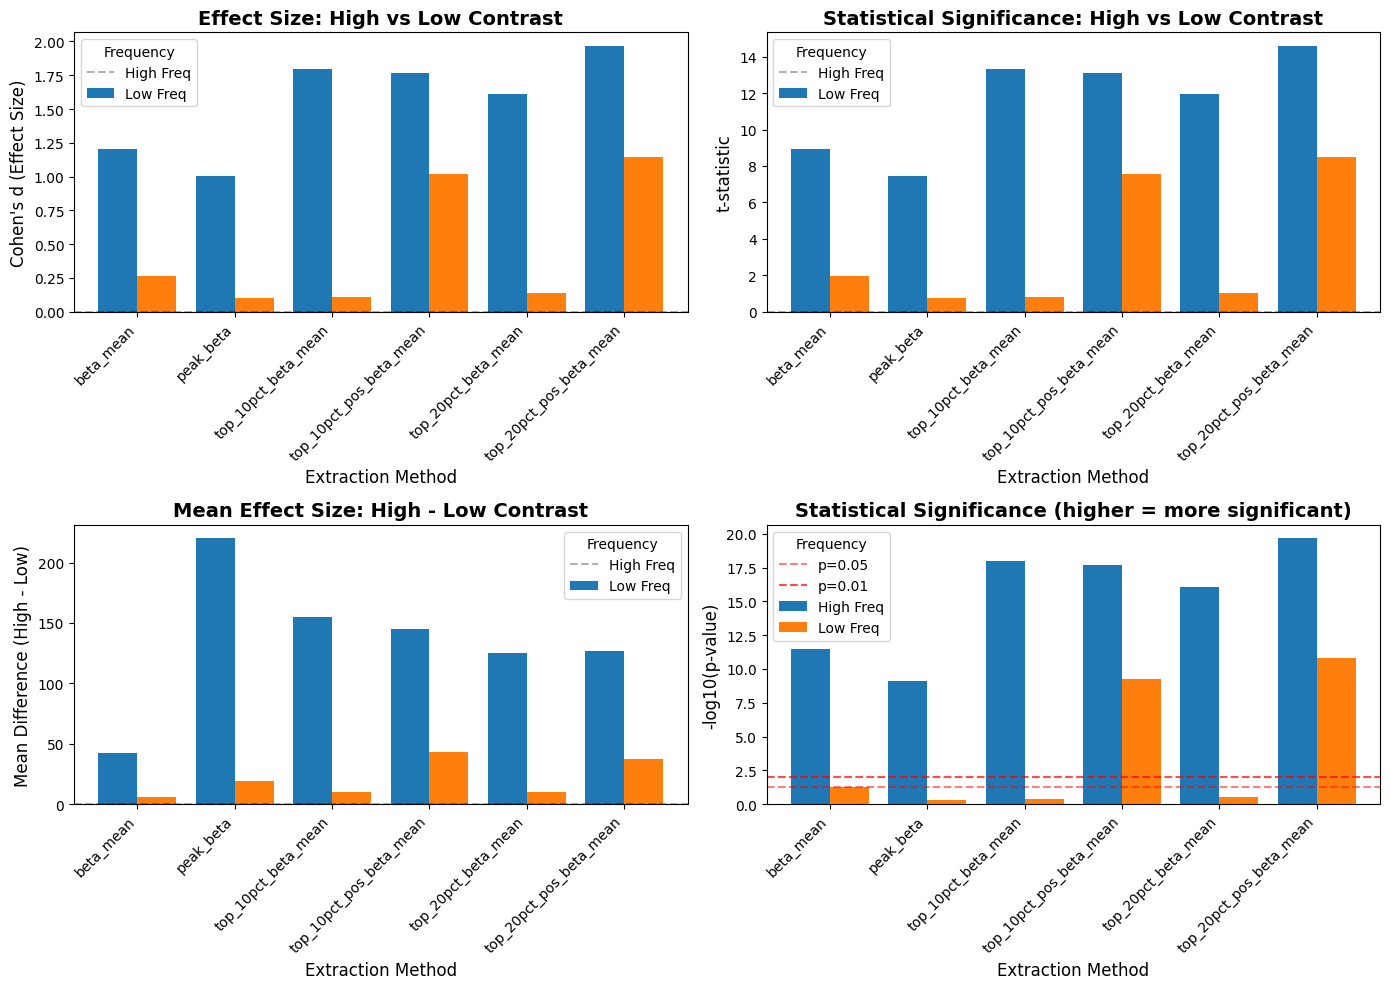

Detailed results saved to 'extraction_method_comparison.csv'


Creating individual subject plots for best method: top_20pct_pos_beta_mean
Individual subject plot saved as 'best_method_individual_subjects.png'


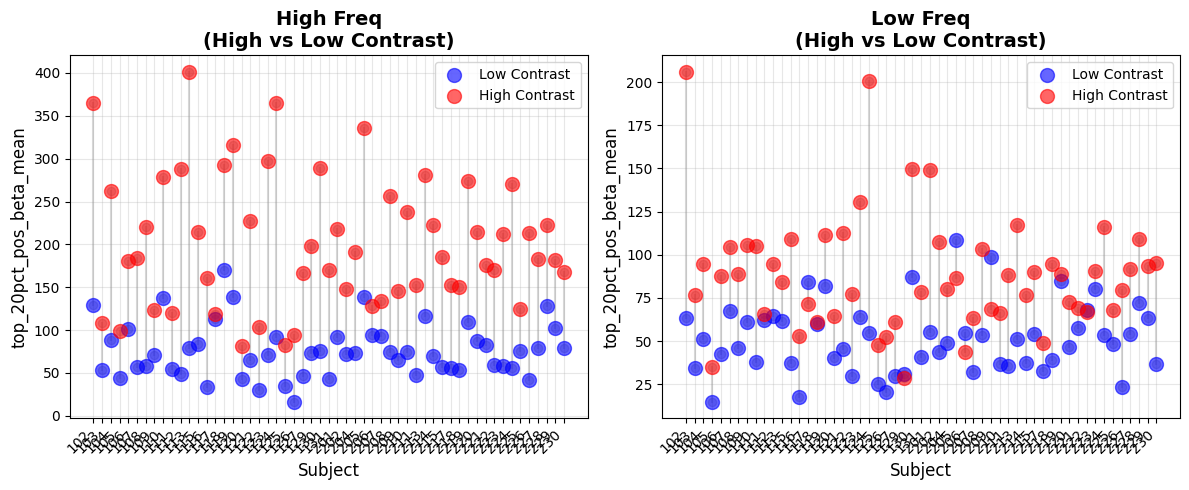


Analysis complete!


In [24]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Extract data for comparison
# -----------------------------

# Define the extraction methods to compare
extraction_methods = [
    'beta_mean',           # Mean across all voxels
    'peak_beta',           # Single peak voxel
    'top_10pct_beta_mean', # Top 10% of voxels (any sign)
    'top_20pct_beta_mean', # Top 20% of voxels (any sign)
    'top_10pct_pos_beta_mean',  # Top 10% of positive voxels
    'top_20pct_pos_beta_mean',  # Top 20% of positive voxels
]

# We'll compare high-high vs high-low (high spatial frequency)
# and low-high vs low-low (low spatial frequency)
contrasts_to_compare = {
    'high_freq': {
        'high_contrast': 'high-high',
        'low_contrast': 'high-low',
    },
    'low_freq': {
        'high_contrast': 'low-high',
        'low_contrast': 'low-low',
    }
}

# Initialize storage for results
comparison_results = []

# Extract data for each subject and method
for method in extraction_methods:
    print(f"\nAnalyzing extraction method: {method}")
    
    for freq_type, contrasts in contrasts_to_compare.items():
        high_contrast_name = contrasts['high_contrast']
        low_contrast_name = contrasts['low_contrast']
        
        # Collect values across subjects
        high_contrast_values = []
        low_contrast_values = []
        
        for sub in all_subject_results.keys():
            # Check if this method exists for this subject
            if method in all_subject_results[sub][high_contrast_name]:
                high_val = all_subject_results[sub][high_contrast_name][method]
                low_val = all_subject_results[sub][low_contrast_name][method]
                
                # Skip if NaN
                if not (np.isnan(high_val) or np.isnan(low_val)):
                    high_contrast_values.append(high_val)
                    low_contrast_values.append(low_val)
        
        # Convert to arrays
        high_contrast_values = np.array(high_contrast_values)
        low_contrast_values = np.array(low_contrast_values)
        
        # Calculate difference (high - low contrast)
        differences = high_contrast_values - low_contrast_values
        
        # Statistical tests
        # Paired t-test
        t_stat, p_value = stats.ttest_rel(high_contrast_values, low_contrast_values)
        
        # Effect size (Cohen's d for paired samples)
        mean_diff = np.mean(differences)
        std_diff = np.std(differences, ddof=1)
        cohens_d = mean_diff / std_diff if std_diff > 0 else 0
        
        # Store results
        comparison_results.append({
            'extraction_method': method,
            'frequency': freq_type,
            'n_subjects': len(high_contrast_values),
            'mean_high_contrast': np.mean(high_contrast_values),
            'mean_low_contrast': np.mean(low_contrast_values),
            'mean_difference': mean_diff,
            'std_difference': std_diff,
            't_statistic': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'significant': p_value < 0.05,
        })
        
        print(f"  {freq_type}: t({len(high_contrast_values)-1}) = {t_stat:.3f}, p = {p_value:.4f}, d = {cohens_d:.3f}")

# Convert to DataFrame
results_df = pd.DataFrame(comparison_results)

# -----------------------------
# Determine best extraction method
# -----------------------------
print("\n" + "="*80)
print("COMPARISON OF EXTRACTION METHODS")
print("="*80)

# Display results sorted by effect size
print("\nResults sorted by Cohen's d (effect size):")
print(results_df.sort_values('cohens_d', ascending=False).to_string(index=False))

# Summary: Which method shows strongest effects?
print("\n" + "-"*80)
print("SUMMARY - Best extraction method per frequency:")
print("-"*80)

for freq_type in ['high_freq', 'low_freq']:
    freq_results = results_df[results_df['frequency'] == freq_type]
    best_method = freq_results.loc[freq_results['cohens_d'].idxmax()]
    
    print(f"\n{freq_type.upper()}:")
    print(f"  Best method: {best_method['extraction_method']}")
    print(f"  Cohen's d: {best_method['cohens_d']:.3f}")
    print(f"  t-statistic: {best_method['t_statistic']:.3f}")
    print(f"  p-value: {best_method['p_value']:.6f}")
    print(f"  Mean difference: {best_method['mean_difference']:.4f}")

# Overall best method (average rank across both frequencies)
print("\n" + "-"*80)
print("OVERALL BEST METHOD (averaged across frequencies):")
print("-"*80)

method_scores = results_df.groupby('extraction_method').agg({
    'cohens_d': 'mean',
    't_statistic': 'mean',
    'p_value': 'mean'
}).sort_values('cohens_d', ascending=False)

print(method_scores)
print(f"\nRecommended extraction method: {method_scores.index[0]}")

# -----------------------------
# Visualization
# -----------------------------

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cohen's d comparison
ax1 = axes[0, 0]
results_pivot = results_df.pivot(index='extraction_method', columns='frequency', values='cohens_d')
results_pivot.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_ylabel("Cohen's d (Effect Size)", fontsize=12)
ax1.set_xlabel("Extraction Method", fontsize=12)
ax1.set_title("Effect Size: High vs Low Contrast", fontsize=14, fontweight='bold')
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.legend(title='Frequency', labels=['High Freq', 'Low Freq'])
ax1.tick_params(axis='x', rotation=45)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: T-statistics
ax2 = axes[0, 1]
results_pivot_t = results_df.pivot(index='extraction_method', columns='frequency', values='t_statistic')
results_pivot_t.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_ylabel("t-statistic", fontsize=12)
ax2.set_xlabel("Extraction Method", fontsize=12)
ax2.set_title("Statistical Significance: High vs Low Contrast", fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.legend(title='Frequency', labels=['High Freq', 'Low Freq'])
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 3: Mean differences
ax3 = axes[1, 0]
results_pivot_diff = results_df.pivot(index='extraction_method', columns='frequency', values='mean_difference')
results_pivot_diff.plot(kind='bar', ax=ax3, width=0.8)
ax3.set_ylabel("Mean Difference (High - Low)", fontsize=12)
ax3.set_xlabel("Extraction Method", fontsize=12)
ax3.set_title("Mean Effect Size: High - Low Contrast", fontsize=14, fontweight='bold')
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax3.legend(title='Frequency', labels=['High Freq', 'Low Freq'])
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 4: P-values (log scale)
ax4 = axes[1, 1]
results_pivot_p = results_df.pivot(index='extraction_method', columns='frequency', values='p_value')
# Plot negative log10 p-values for better visualization
(-np.log10(results_pivot_p)).plot(kind='bar', ax=ax4, width=0.8)
ax4.set_ylabel("-log10(p-value)", fontsize=12)
ax4.set_xlabel("Extraction Method", fontsize=12)
ax4.set_title("Statistical Significance (higher = more significant)", fontsize=14, fontweight='bold')
ax4.axhline(y=-np.log10(0.05), color='r', linestyle='--', alpha=0.5, label='p=0.05')
ax4.axhline(y=-np.log10(0.01), color='r', linestyle='--', alpha=0.7, label='p=0.01')
ax4.legend(title='Frequency', labels=['p=0.05', 'p=0.01','High Freq', 'Low Freq'])
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('extraction_method_comparison.png', dpi=300, bbox_inches='tight')
print("\n\nFigure saved as 'extraction_method_comparison.png'")
plt.show()

# -----------------------------
# Save detailed results
# -----------------------------
results_df.to_csv('extraction_method_comparison.csv', index=False)
print("Detailed results saved to 'extraction_method_comparison.csv'")

# -----------------------------
# Additional visualization: Individual subject data
# -----------------------------

# Pick the best method overall for visualization
best_method = method_scores.index[0]

print(f"\n\nCreating individual subject plots for best method: {best_method}")

fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))

for idx, (freq_type, contrasts) in enumerate(contrasts_to_compare.items()):
    high_contrast_name = contrasts['high_contrast']
    low_contrast_name = contrasts['low_contrast']
    
    # Collect data
    subjects = []
    high_vals = []
    low_vals = []
    
    for sub in all_subject_results.keys():
        if best_method in all_subject_results[sub][high_contrast_name]:
            high_val = all_subject_results[sub][high_contrast_name][best_method]
            low_val = all_subject_results[sub][low_contrast_name][best_method]
            
            if not (np.isnan(high_val) or np.isnan(low_val)):
                subjects.append(sub)
                high_vals.append(high_val)
                low_vals.append(low_val)
    
    # Create paired plot
    ax = axes2[idx]
    x_pos = np.arange(len(subjects))
    
    ax.plot([x_pos, x_pos], [low_vals, high_vals], 'o-', color='gray', alpha=0.3)
    ax.scatter(x_pos, low_vals, color='blue', s=100, alpha=0.6, label='Low Contrast', zorder=3)
    ax.scatter(x_pos, high_vals, color='red', s=100, alpha=0.6, label='High Contrast', zorder=3)
    
    ax.set_xlabel('Subject', fontsize=12)
    ax.set_ylabel(f'{best_method}', fontsize=12)
    ax.set_title(f'{freq_type.replace("_", " ").title()}\n(High vs Low Contrast)', 
                 fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(subjects, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('best_method_individual_subjects.png', dpi=300, bbox_inches='tight')
print("Individual subject plot saved as 'best_method_individual_subjects.png'")
plt.show()

print("\n" + "="*80)
print("Analysis complete!")
print("="*80)

#### Group x SF comparison


Group assignments:
  Patients: N=28
  Controls: N=27

EXTRACTING AND NORMALIZING DATA

Total observations: 110
Subjects: 55
Controls: 27
Patients: 28

Sample data:
  subject    group spatial_frequency  high_contrast_beta  low_contrast_beta  \
0     102  patient              high          364.951566         128.803145   
1     102  patient               low          205.903298          63.283870   
2     103  patient              high          108.704341          53.181780   
3     103  patient               low           76.419132          34.487804   
4     104  patient              high          262.273285          88.243709   
5     104  patient               low           94.865556          50.959273   
6     105  patient              high           99.324335          43.909540   
7     105  patient               low           35.045536          14.979318   
8     106  patient              high          180.604849         101.578891   
9     106  patient               low         

/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/2277376119.py:341: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['High SF', 'Low SF'])
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/2277376119.py:352: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(['High SF', 'Low SF'])
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/2277376119.py:382: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=diff_df, x='group', y='sf_difference', ax=ax6,
/var/folders/hq/ms5zk3kj1pd2kwh1bnvtcr0m0000gn/T/ipykernel_20688/2277376119.py:390: UserWarning: set_ticklabels() should only be used with a fixed number


Visualization saved as 'group_comparison_analysis.png'


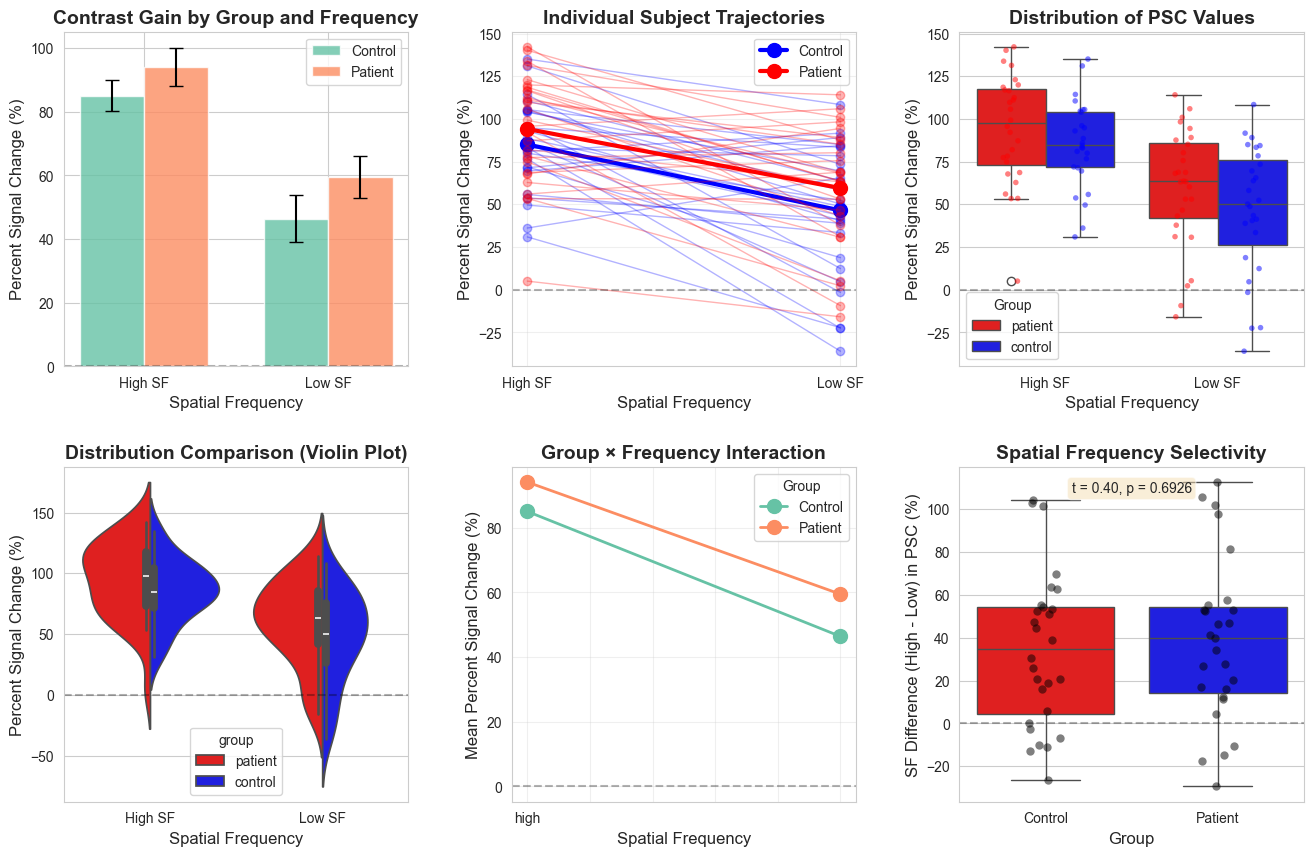


ANALYSIS COMPLETE!

Generated files:
  - normalized_contrast_data.csv
  - mixed_model_results.txt
  - group_comparison_analysis.png


In [35]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import mixedlm
import statsmodels.api as sm

# -----------------------------
# Configuration
# -----------------------------

# Best extraction method (from previous analysis)
extraction_method = 'top_20pct_pos_beta_mean'

# Define group assignments based on subject list
patients = subjects[0:28]
controls = subjects[28:]

# Create group assignment dictionary
group_assignments = {}
for sub in patients:
    group_assignments[sub] = 'patient'
for sub in controls:
    group_assignments[sub] = 'control'

print(f"\nGroup assignments:")
print(f"  Patients: N={len(patients)}")
print(f"  Controls: N={len(controls)}")

# -----------------------------
# Extract and normalize data
# -----------------------------

print("\n" + "="*80)
print("EXTRACTING AND NORMALIZING DATA")
print("="*80)

data_list = []

for sub in all_subject_results.keys():
    # Get group assignment
    if sub not in group_assignments:
        print(f"Warning: Subject {sub} not in group assignments, skipping")
        continue
    
    group = group_assignments[sub]
    
    # Extract values for each spatial frequency
    for freq_type in ['high', 'low']:
        # Get high and low contrast values
        high_contrast = f'{freq_type}-high'
        low_contrast = f'{freq_type}-low'
        
        # Check if data exists
        if (high_contrast not in all_subject_results[sub] or 
            low_contrast not in all_subject_results[sub]):
            continue
        
        high_val = all_subject_results[sub][high_contrast][extraction_method]
        low_val = all_subject_results[sub][low_contrast][extraction_method]
        
        # Skip if NaN
        if np.isnan(high_val) or np.isnan(low_val):
            print(f"Warning: NaN values for subject {sub}, {freq_type} frequency")
            continue
        
        # Calculate percent signal change: ((high - low) / low) * 100
        # Alternative: ((high - low) / ((high + low) / 2)) * 100 for symmetric measure
        baseline = (np.abs(high_val) + np.abs(low_val)) / 2
        if baseline != 0:
            psc = ((high_val - low_val) / baseline) * 100
        else:
            psc = np.nan
            print(f"Warning: Zero baseline for subject {sub}, {freq_type} frequency")
            continue
        
        # Also calculate raw difference for comparison
        raw_diff = high_val - low_val
        
        # Store data
        data_list.append({
            'subject': sub,
            'group': group,
            'spatial_frequency': freq_type,
            'high_contrast_beta': high_val,
            'low_contrast_beta': low_val,
            'percent_signal_change': psc,
            'raw_difference': raw_diff,
        })

# Create DataFrame
data_df = pd.DataFrame(data_list)

print(f"\nTotal observations: {len(data_df)}")
print(f"Subjects: {data_df['subject'].nunique()}")
print(f"Controls: {(data_df['group'] == 'control').sum() // 2}")  # Divide by 2 because each subject has 2 frequencies
print(f"Patients: {(data_df['group'] == 'patient').sum() // 2}")

# Display sample data
print("\nSample data:")
print(data_df.head(10))

# Save the normalized data
data_df.to_csv('normalized_contrast_data.csv', index=False)
print("\nNormalized data saved to 'normalized_contrast_data.csv'")

# -----------------------------
# Descriptive Statistics
# -----------------------------

print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS")
print("="*80)

# Summary statistics by group and frequency
summary_stats = data_df.groupby(['group', 'spatial_frequency']).agg({
    'percent_signal_change': ['mean', 'std', 'count'],
    'raw_difference': ['mean', 'std']
}).round(3)

print("\nPercent Signal Change by Group and Frequency:")
print(summary_stats)

# -----------------------------
# Statistical Analysis: Mixed Model
# -----------------------------

print("\n" + "="*80)
print("MIXED MODEL ANALYSIS")
print("="*80)

# Create dummy variables for categorical predictors
data_df['group_code'] = (data_df['group'] == 'patient').astype(int)  # 0 = control, 1 = patient
data_df['freq_code'] = (data_df['spatial_frequency'] == 'low').astype(int)  # 0 = high, 1 = low

# Fit mixed effects model with random intercepts for subjects
# Formula: PSC ~ group + frequency + group*frequency + (1 | subject)
try:
    model = mixedlm(
        "percent_signal_change ~ group_code + freq_code + group_code:freq_code",
        data=data_df,
        groups=data_df["subject"]
    )
    result = model.fit()
    
    print("\nMixed Model Results:")
    print(result.summary())
    
    # Extract key statistics
    print("\n" + "-"*80)
    print("KEY FINDINGS:")
    print("-"*80)
    
    params = result.params
    pvalues = result.pvalues
    
    print(f"\nMain Effect of Group (Patient vs Control):")
    print(f"  Coefficient: {params['group_code']:.4f}")
    print(f"  p-value: {pvalues['group_code']:.6f}")
    print(f"  Significant: {'YES' if pvalues['group_code'] < 0.05 else 'NO'}")
    
    print(f"\nMain Effect of Spatial Frequency (Low vs High):")
    print(f"  Coefficient: {params['freq_code']:.4f}")
    print(f"  p-value: {pvalues['freq_code']:.6f}")
    print(f"  Significant: {'YES' if pvalues['freq_code'] < 0.05 else 'NO'}")
    
    print(f"\nGroup × Spatial Frequency Interaction:")
    print(f"  Coefficient: {params['group_code:freq_code']:.4f}")
    print(f"  p-value: {pvalues['group_code:freq_code']:.6f}")
    print(f"  Significant: {'YES' if pvalues['group_code:freq_code'] < 0.05 else 'NO'}")
    
    # Save model results
    with open('mixed_model_results.txt', 'w') as f:
        f.write(str(result.summary()))
    print("\nModel results saved to 'mixed_model_results.txt'")
    
except Exception as e:
    print(f"Error fitting mixed model: {e}")
    print("Falling back to repeated measures ANOVA...")
    result = None

# -----------------------------
# Alternative: Repeated Measures ANOVA
# -----------------------------

if result is None:
    print("\n" + "="*80)
    print("REPEATED MEASURES ANOVA (Alternative Analysis)")
    print("="*80)
    
    from statsmodels.stats.anova import AnovaRM
    
    try:
        # Reshape data for RM-ANOVA
        rm_anova = AnovaRM(
            data=data_df,
            depvar='percent_signal_change',
            subject='subject',
            within=['spatial_frequency'],
            between=['group']
        )
        rm_result = rm_anova.fit()
        print(rm_result)
        
    except Exception as e:
        print(f"Error with RM-ANOVA: {e}")

# -----------------------------
# Post-hoc Tests
# -----------------------------

print("\n" + "="*80)
print("POST-HOC TESTS")
print("="*80)

# Simple effects: Group differences at each frequency
for freq in ['high', 'low']:
    freq_data = data_df[data_df['spatial_frequency'] == freq]
    control_vals = freq_data[freq_data['group'] == 'control']['percent_signal_change']
    patient_vals = freq_data[freq_data['group'] == 'patient']['percent_signal_change']
    
    if len(control_vals) > 0 and len(patient_vals) > 0:
        t_stat, p_val = stats.ttest_ind(control_vals, patient_vals)
        cohens_d = (np.mean(control_vals) - np.mean(patient_vals)) / np.sqrt(
            ((len(control_vals)-1)*np.var(control_vals, ddof=1) + 
             (len(patient_vals)-1)*np.var(patient_vals, ddof=1)) / 
            (len(control_vals) + len(patient_vals) - 2)
        )
        
        print(f"\n{freq.upper()} Spatial Frequency - Group Comparison:")
        print(f"  Controls: M={np.mean(control_vals):.2f}, SD={np.std(control_vals, ddof=1):.2f}, N={len(control_vals)}")
        print(f"  Patients: M={np.mean(patient_vals):.2f}, SD={np.std(patient_vals, ddof=1):.2f}, N={len(patient_vals)}")
        print(f"  t({len(control_vals)+len(patient_vals)-2}) = {t_stat:.3f}, p = {p_val:.6f}")
        print(f"  Cohen's d = {cohens_d:.3f}")

# Simple effects: Frequency differences within each group
for group in ['control', 'patient']:
    group_data = data_df[data_df['group'] == group]
    high_vals = group_data[group_data['spatial_frequency'] == 'high']['percent_signal_change']
    low_vals = group_data[group_data['spatial_frequency'] == 'low']['percent_signal_change']
    
    # Need to match subjects for paired test
    high_dict = dict(zip(
        group_data[group_data['spatial_frequency'] == 'high']['subject'],
        high_vals
    ))
    low_dict = dict(zip(
        group_data[group_data['spatial_frequency'] == 'low']['subject'],
        low_vals
    ))
    
    # Get matched pairs
    common_subs = set(high_dict.keys()) & set(low_dict.keys())
    high_matched = [high_dict[s] for s in common_subs]
    low_matched = [low_dict[s] for s in common_subs]
    
    if len(high_matched) > 0:
        t_stat, p_val = stats.ttest_rel(high_matched, low_matched)
        cohens_d = np.mean(np.array(high_matched) - np.array(low_matched)) / np.std(
            np.array(high_matched) - np.array(low_matched), ddof=1
        )
        
        print(f"\n{group.upper()} Group - Spatial Frequency Comparison:")
        print(f"  High SF: M={np.mean(high_matched):.2f}, SD={np.std(high_matched, ddof=1):.2f}")
        print(f"  Low SF: M={np.mean(low_matched):.2f}, SD={np.std(low_matched, ddof=1):.2f}")
        print(f"  t({len(high_matched)-1}) = {t_stat:.3f}, p = {p_val:.6f}")
        print(f"  Cohen's d = {cohens_d:.3f}")

# -----------------------------
# Visualizations
# -----------------------------

print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Set style
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Create figure with multiple subplots
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Plot 1: Bar plot with error bars
ax1 = fig.add_subplot(gs[0, 0])
summary_for_plot = data_df.groupby(['group', 'spatial_frequency'])['percent_signal_change'].agg(['mean', 'sem']).reset_index()
x = np.arange(2)
width = 0.35

for i, group in enumerate(['control', 'patient']):
    group_data = summary_for_plot[summary_for_plot['group'] == group]
    means = group_data['mean'].values
    sems = group_data['sem'].values
    ax1.bar(x + i*width, means, width, yerr=sems, label=group.capitalize(), 
            capsize=5, alpha=0.8)

ax1.set_ylabel('Percent Signal Change (%)', fontsize=12)
ax1.set_xlabel('Spatial Frequency', fontsize=12)
ax1.set_title('Contrast Gain by Group and Frequency', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width / 2)
ax1.set_xticklabels(['High SF', 'Low SF'])
ax1.legend()
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Plot 2: Individual subjects as lines
ax2 = fig.add_subplot(gs[0, 1])
for group, color in zip(['control', 'patient'], ['blue', 'red']):
    group_data = data_df[data_df['group'] == group]
    for subject in group_data['subject'].unique():
        sub_data = group_data[group_data['subject'] == subject].sort_values('spatial_frequency')
        if len(sub_data) == 2:  # Only if we have both frequencies
            ax2.plot(['High SF', 'Low SF'], 
                    sub_data['percent_signal_change'].values,
                    'o-', color=color, alpha=0.3, linewidth=1)
    
    # Add group means
    group_means = group_data.groupby('spatial_frequency')['percent_signal_change'].mean()
    ax2.plot(['High SF', 'Low SF'], 
            [group_means['high'], group_means['low']],
            'o-', color=color, linewidth=3, markersize=10, label=group.capitalize())

ax2.set_ylabel('Percent Signal Change (%)', fontsize=12)
ax2.set_xlabel('Spatial Frequency', fontsize=12)
ax2.set_title('Individual Subject Trajectories', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Plot 3: Box plots
ax3 = fig.add_subplot(gs[0, 2])
sns.boxplot(data=data_df, x='spatial_frequency', y='percent_signal_change', 
            hue='group', ax=ax3, palette={'control': 'blue', 'patient': 'red'})
sns.stripplot(data=data_df, x='spatial_frequency', y='percent_signal_change', 
              hue='group', ax=ax3, dodge=True, alpha=0.5, size=4,
              palette={'control': 'blue', 'patient': 'red'}, legend=False)
ax3.set_ylabel('Percent Signal Change (%)', fontsize=12)
ax3.set_xlabel('Spatial Frequency', fontsize=12)
ax3.set_title('Distribution of PSC Values', fontsize=14, fontweight='bold')
ax3.set_xticklabels(['High SF', 'Low SF'])
ax3.legend(title='Group')
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Plot 4: Violin plots
ax4 = fig.add_subplot(gs[1, 0])
sns.violinplot(data=data_df, x='spatial_frequency', y='percent_signal_change', 
               hue='group', ax=ax4, split=True, palette={'control': 'blue', 'patient': 'red'})
ax4.set_ylabel('Percent Signal Change (%)', fontsize=12)
ax4.set_xlabel('Spatial Frequency', fontsize=12)
ax4.set_title('Distribution Comparison (Violin Plot)', fontsize=14, fontweight='bold')
ax4.set_xticklabels(['High SF', 'Low SF'])
ax4.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Plot 5: Interaction plot
ax5 = fig.add_subplot(gs[1, 1])
interaction_data = data_df.groupby(['group', 'spatial_frequency'])['percent_signal_change'].mean().unstack()
interaction_data.T.plot(ax=ax5, marker='o', markersize=10, linewidth=2)
ax5.set_ylabel('Mean Percent Signal Change (%)', fontsize=12)
ax5.set_xlabel('Spatial Frequency', fontsize=12)
ax5.set_title('Group × Frequency Interaction', fontsize=14, fontweight='bold')
ax5.legend(title='Group', labels=['Control', 'Patient'])
ax5.grid(True, alpha=0.3)
ax5.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Plot 6: Difference scores (high - low SF) by group
ax6 = fig.add_subplot(gs[1, 2])
diff_data = []
for sub in data_df['subject'].unique():
    sub_data = data_df[data_df['subject'] == sub]
    if len(sub_data) == 2:
        high_val = sub_data[sub_data['spatial_frequency'] == 'high']['percent_signal_change'].values[0]
        low_val = sub_data[sub_data['spatial_frequency'] == 'low']['percent_signal_change'].values[0]
        group = sub_data['group'].values[0]
        diff_data.append({
            'subject': sub,
            'group': group,
            'sf_difference': high_val - low_val
        })

diff_df = pd.DataFrame(diff_data)
sns.boxplot(data=diff_df, x='group', y='sf_difference', ax=ax6,
            palette={'control': 'blue', 'patient': 'red'})
sns.stripplot(data=diff_df, x='group', y='sf_difference', ax=ax6,
              alpha=0.5, size=6, color='black')
ax6.set_ylabel('SF Difference (High - Low) in PSC (%)', fontsize=12)
ax6.set_xlabel('Group', fontsize=12)
ax6.set_title('Spatial Frequency Selectivity', fontsize=14, fontweight='bold')
ax6.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax6.set_xticklabels(['Control', 'Patient'])

# Test difference in SF selectivity
control_diff = diff_df[diff_df['group'] == 'control']['sf_difference']
patient_diff = diff_df[diff_df['group'] == 'patient']['sf_difference']
if len(control_diff) > 0 and len(patient_diff) > 0:
    t_stat, p_val = stats.ttest_ind(control_diff, patient_diff)
    ax6.text(0.5, ax6.get_ylim()[1]*0.9, f't = {t_stat:.2f}, p = {p_val:.4f}',
            ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.savefig('group_comparison_analysis.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'group_comparison_analysis.png'")
plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated files:")
print("  - normalized_contrast_data.csv")
print("  - mixed_model_results.txt")
print("  - group_comparison_analysis.png")